# 0. Import libraries and load Data

Install required Python packages using pip package manager

In [1]:
!pip install pandas -q          # pandas: provides data manipulation and analysis tools
!pip install numpy -q           # numpy: provides support for numerical operations
!pip install matplotlib -q      # matplotlib: provides data visualization tools
!pip install seaborn -q         # seaborn: provides advanced data visualization tools
!pip install scikit-learn -q    # scikit-learn: provides machine learning algorithms
!pip install scipy -q           # scipy: provides scientific computing functions


Import required Python libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
import math
import seaborn as sns
from matplotlib import colors

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.preprocessing import Normalizer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import GridSearchCV

reads the 'csv' files and store the data in DataFrames

In [3]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
poi_df = pd.read_csv('data/poi.csv')

/tmp/ipykernel_26679/4245473066.py:3: DtypeWarning: Columns (7,9,11,13,17,18,19,22,23,24,25,26,28,29,30,32,33,34,35,36,37,38,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,74,77,80,82,83,84,85,86,87,90,91,92,95) have mixed types. Specify dtype option on import or set low_memory=False.
  poi_df = pd.read_csv('data/poi.csv')


# 1. Data Preparing

# 1.0. Utilities Functions

In [4]:
def NaN_analysis(df):
    """
    Computes two types of analyses on the input pandas DataFrame:
    
    1. Percentage of NaN values in each column, sorted in descending order of percentage.
    2. Number of rows with a specific number of NaN values, up to the total number of columns in the input DataFrame.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The DataFrame to be analyzed.
    
    Returns:
    --------
    analysis1 : pandas DataFrame
        The percentage of NaN values in each column, sorted in descending order of percentage.
    analysis2 : pandas DataFrame
        The number of rows with a specific number of NaN values, up to the total number of columns in the input DataFrame.
    """
    # analysis1: percentage of NaN values in columns
    d = {'column': [], 'n_nan': [], 'percentage': []}
    for col in df.columns:
        n_nan = df[(df[col].isna())].shape[0]
        d['column'].append(col)
        d['n_nan'].append(n_nan)
        d['percentage'].append((n_nan*100)/df.shape[0])
    analysis1 = pd.DataFrame(d).sort_values('percentage', ascending=False).reset_index(drop=True)
    # analysis2: number of NaN values in each row grouped by number of NaN values
    analysis2 = df.isna().sum(axis=1)
    analysis2 = analysis2.value_counts().to_frame().reset_index().sort_values('index', ascending=False).reset_index(drop=True).rename(columns={'index': 'n_nan', 'count': 'n_rows'})
    return analysis1, analysis2

In [5]:
def groupby_count_percentage(df, col):
    tmp = df[col].to_frame().copy()
    tmp.fillna('NaN', inplace=True)
    tmp['count'] = 0
    tmp = tmp.groupby(col).count().reset_index().sort_values('count', ascending=False).reset_index(drop=True)
    tmp['percentage'] = (tmp['count']*100)/df.shape[0]
    return tmp

In [6]:
def hist_subplot(df, feature, b=100):
    df = df.dropna(subset=[feature]).reset_index(drop=True) #before plotting we remove the NaNs otherwise it will not be possible to plot the graphs 
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    axs[0].hist(df[feature], bins=b)
    axs[0].set_title('Histogram distribution of {}'.format(feature))
    axs[0].set_ylabel('Count')
    axs[0].set_xlabel('Value')
    axs[1].hist2d(pd.Series(np.array([i for i in range(df.loc[:, feature].shape[0])])), df.loc[:, feature], bins=b, norm=colors.LogNorm())
    axs[1].set_title('2D histogram distribution of {}'.format(feature))
    axs[1].set_ylabel('Value')
    axs[1].set_xlabel('Index')
    plt.tight_layout()
    plt.show()
    return

# 1.1. Point of Interest Analysis

In [7]:
poi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397382 entries, 0 to 397381
Data columns (total 96 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id_on_platform         397382 non-null  int64  
 1   lat                    397382 non-null  float64
 2   lon                    397382 non-null  float64
 3   source                 397382 non-null  object 
 4   tags.addr:city         80929 non-null   object 
 5   tags.addr:country      32852 non-null   object 
 6   tags.addr:housenumber  104548 non-null  object 
 7   tags.addr:postcode     64669 non-null   object 
 8   tags.addr:street       97486 non-null   object 
 9   tags.alt_name:gl       1 non-null       object 
 10  tags.amenity           50459 non-null   object 
 11  tags.artwork_type      662 non-null     object 
 12  tags.barrier           42890 non-null   object 
 13  tags.bicycle           3878 non-null    object 
 14  tags.brand             4342 non-null

Performiamo la NaN analysis su poi_df

In [8]:
analysis1, analysis2 = NaN_analysis(poi_df)

In [9]:
analysis1

column   n_nan  percentage
0        tags.alt_name:gl  397381   99.999748
1     tags.source:name:oc  397381   99.999748
2      tags.name:east2276  397381   99.999748
3            tags.name:za  397381   99.999748
4          tags.ref:ISTAT  397380   99.999497
..                    ...     ...         ...
91  tags.addr:housenumber  292834   73.690806
92                    lon       0    0.000000
93                 source       0    0.000000
94                    lat       0    0.000000
95         id_on_platform       0    0.000000

[96 rows x 3 columns]

In [10]:
analysis2

n_nan  n_rows
0      92  106013
1      91  102752
2      90   66381
3      89   26608
4      88   40318
5      87   37835
6      86    9904
7      85    4386
8      84    1632
9      83     830
10     82     402
11     81     157
12     80      94
13     79      26
14     78      18
15     77       8
16     76       4
17     75       1
18     74       2
19     73       2
20     72       1
21     66       1
22     64       1
23     55       1
24     50       2
25     49       1
26     45       1
27     39       1

notiamo che la maggior parte delle colonne contengono NaN. Ci limiteremo ad utilizzare unicamente le colonne lat, lon per aggiungere eventuali features

In [11]:
poi_df = poi_df.filter(['lat', 'lon'])

Plottando lo scatterplot delle coordinate possiamo notare la distribuzione dei punti di interesse

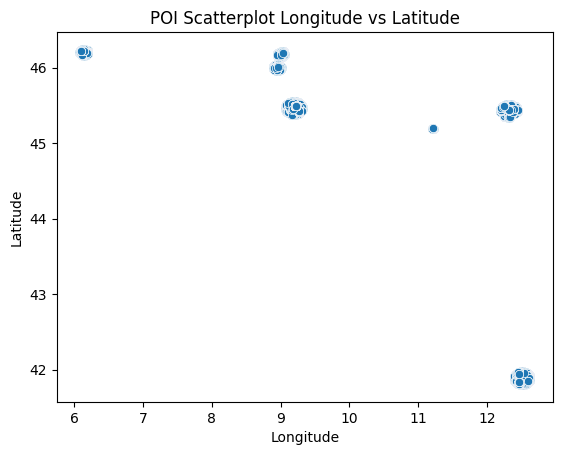

In [12]:
sns.scatterplot(x='lon', y='lat', data=poi_df)
plt.title('POI Scatterplot Longitude vs Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

# 1.2. Train Dataset Analysis

Droppiamo la colonna id da train_df, cosi da lasciare in train_df solo le colonne delle features e la colonna delle predictions

In [13]:
# drop id
train_df.drop('id', axis=1, inplace=True)

Performiamo la NaN analysis su train_df

In [14]:
analysis1, analysis2 = NaN_analysis(train_df)

In [15]:
analysis1

column  n_nan  percentage
0                garden  31529   68.079547
1     energy_efficiency  19903   42.975903
2          total_floors  18349   39.620401
3              elevator  17443   37.664104
4              expenses  16154   34.880808
5               balcony  15443   33.345569
6     construction_year  13946   30.113146
7           n_bathrooms   2416    5.216790
8                 floor   2031    4.385472
9            conditions   1229    2.653740
10              surface    443    0.956556
11              n_rooms    353    0.762221
12             latitude     13    0.028070
13            longitude     13    0.028070
14  proximity_to_center     13    0.028070
15                price      0    0.000000

In [16]:
analysis2

n_nan  n_rows
0      12       1
1      11       3
2      10     172
3       9     147
4       8     536
5       7    1295
6       6    3230
7       5    5605
8       4    6704
9       3    7330
10      2    8784
11      1    9058
12      0    3447

# 1.3. Add Features

Aggiungiamo la feature n_poi

In [17]:
def get_n_poi(lat, lon, poi_df, radius=0.001):
    if math.isnan(lat) or math.isnan(lon):
        return np.nan
    # get all poi in a certain radius from the current lat and lon
    series = poi_df[(poi_df['lat']-lat)**2 + (poi_df['lon']-lon)**2 <= radius**2]
    # n_poi = np.nan if series.shape[0] == 0 else series.shape[0]
    return series.shape[0] # n_poi

In [18]:
train_df['n_poi'] = train_df.apply(lambda x: get_n_poi(x['latitude'], x['longitude'], poi_df), axis=1)

Aggiungiamo la feature ratio

In [19]:
def lambda_ratio(x):
    n_room = x['n_rooms']
    n_bathroom = x['n_bathrooms']
    if not math.isnan(n_room) and not math.isnan(n_bathroom):
        return n_room/max(1, n_bathroom) 
    else:
        return np.nan

In [20]:
train_df['ratio'] = train_df.apply(lambda x: lambda_ratio(x), axis=1)

Aggiungiamo la feature m2_per_bathrooms

In [21]:
def lambda_m2_per_bathrooms(x):
    n_room = x['n_rooms']
    n_bathroom = x['n_bathrooms']
    m2 = x['surface']
    if not math.isnan(n_bathroom) and not math.isnan(m2):
        return m2/max(1, n_room*3 + n_bathroom)
    else:
        return np.nan

In [22]:
train_df['m2_per_bathrooms'] = train_df.apply(lambda x: lambda_m2_per_bathrooms(x), axis=1)

Prima di rimuovere i NaN aggiungiamo una feature chiamata confidence che ci indica per ogni riga quanti valori non NaN aveva in origine 

In [23]:
train_df['confidence'] = train_df.shape[1] - train_df.isna().sum(axis=1) - 3 # 3 corrisponde a non contare price balcony e garden che per costruzione non sono mai NaN

Mostriamo il train_df a seguito dell'aggiunta delle features

In [24]:
train_df

price balcony               conditions  construction_year   latitude   
0       60000    True  Buono stato / Abitabile             1980.0  41.901300  \
1      900000     NaN  Buono stato / Abitabile                NaN  41.907017   
2       33000     NaN  Buono stato / Abitabile             1960.0  41.976500   
3      166000     NaN   Ottimo / Ristrutturato                NaN  45.484800   
4      410000    True  Buono stato / Abitabile                NaN  45.424480   
...       ...     ...                      ...                ...        ...   
46307  329999    True  Buono stato / Abitabile             1929.0  41.923500   
46308  599000    True         Da ristrutturare             1920.0  41.916743   
46309  549000    True  Buono stato / Abitabile                NaN  45.454701   
46310  189000    True  Buono stato / Abitabile             1965.0  45.445605   
46311  355000    True   Ottimo / Ristrutturato             1970.0  41.877000   

       longitude  energy_efficiency  expenses  floor garden  n_bathrooms   
0      12.700000             175.00      30.0    2.0    NaN          1.0  \
1      12.481311                NaN       NaN    3.0    NaN          1.0   
2      12.440500             204.20      30.0    4.0    NaN          1.0   
3      12.198200             175.00       NaN    1.0   True          1.0   
4      12.328622              65.91       NaN    3.0    NaN          2.0   
...          ...                ...       ...    ...    ...          ...   
46307  12.446100             175.00      35.0    3.0    NaN          1.0   
46308  12.454925                NaN     170.0    6.0    NaN          2.0   
46309   9.242711                NaN       NaN    NaN    NaN          2.0   
46310   9.245942                NaN     150.0   -1.0   True          1.0   
46311  12.431400             175.00     100.0    1.0    NaN          1.0   

       elevator  total_floors  n_rooms  proximity_to_center  surface  n_poi   
0           NaN           3.0      1.0              1.00000     35.0    0.0  \
1           1.0           NaN      3.0              1.00000    131.0   25.0   
2           NaN           4.0      1.0              1.00000     16.0    0.0   
3           NaN           1.0      2.0              0.99205    100.0    0.0   
4           1.0           NaN      3.0              1.00000     90.0    8.0   
...         ...           ...      ...                  ...      ...    ...   
46307       NaN           4.0      3.0              1.00000     88.0   22.0   
46308       1.0           NaN      5.0              1.00000    189.0   56.0   
46309       1.0           NaN      3.0              1.00000    140.0    6.0   
46310       1.0           NaN      3.0              1.00000     70.0   38.0   
46311       1.0           5.0      4.0              1.00000    101.0    5.0   

       ratio  m2_per_bathrooms  confidence  
0        1.0          8.750000          14  
1        3.0         13.100000          10  
2        1.0          4.000000          13  
3        2.0         14.285714          12  
4        1.5          8.181818          12  
...      ...               ...         ...  
46307    3.0          8.800000          14  
46308    2.5         11.117647          13  
46309    1.5         12.727273          10  
46310    3.0          7.000000          14  
46311    4.0          7.769231          15  

[46312 rows x 20 columns]

# 1.4. NaN Issues

We can notice that for the features balcony and garden the NaN are actually 'False'. So we replace NaN with False

In [25]:
groupby_count_percentage(train_df, 'balcony')

balcony  count  percentage
0    True  30869   66.654431
1     NaN  15443   33.345569

In [26]:
groupby_count_percentage(train_df, 'garden')

garden  count  percentage
0    NaN  31529   68.079547
1   True  14783   31.920453

In [27]:
train_df['garden'] = train_df['garden'].fillna(False)
train_df['balcony'] = train_df['balcony'].fillna(False)

We encode garden, balcony and condition. In order to have for each feature only int or float as data, in this way we can plot graphs to better understand what to do with the NaN if drop or fix them. 
\
We have to point out that we encode condition with the assumption that also the test data will have the same labels as the train data for the feature condition.

In [28]:
train_df['garden'] = train_df['garden'].apply(lambda x: 1 if x == True else 0)
train_df['balcony'] = train_df['balcony'].apply(lambda x: 1 if x == True else 0)

Trasformiamo anche la feature categorica 'conditions' in una features numerica

In [29]:
map_conditions = {}
index = 0
for value in train_df['conditions'].unique():
    if value not in map_conditions:
        map_conditions[value] = index
        index += 1
map_conditions

{'Buono stato / Abitabile': 0,
 'Ottimo / Ristrutturato': 1,
 'Da ristrutturare': 2,
 'Nuovo / Nuova costruzione': 3,
 nan: 4}

In [30]:
train_df['conditions'] = train_df['conditions'].apply(lambda x: map_conditions[x])
train_df['conditions'] = train_df['conditions'].apply(lambda x: np.nan if x == map_conditions[np.nan] else x)

For each column that has at least a NaN as a data we plot the histogram distribution also in 2D

In [31]:
columns_wnan = []
for col in train_df.columns:
    if train_df[train_df[col].isna()].shape[0] > 0:
        columns_wnan.append(col)
columns_wnan

['conditions',
 'construction_year',
 'latitude',
 'longitude',
 'energy_efficiency',
 'expenses',
 'floor',
 'n_bathrooms',
 'elevator',
 'total_floors',
 'n_rooms',
 'proximity_to_center',
 'surface',
 'n_poi',
 'ratio',
 'm2_per_bathrooms']

plottando gli istogrammi delle features con i NaN notiamo che ci sono abbastanza saples distribuiti, non NaN, che possono permetterci di fillare i NaN con tecniche apposite (come KNNImputer).

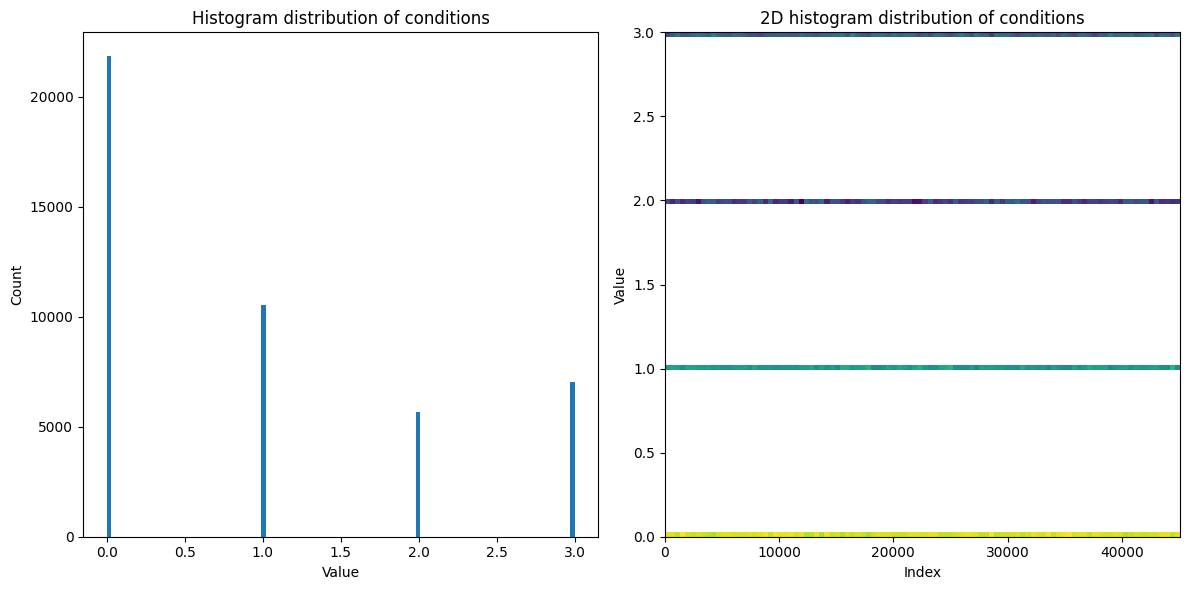

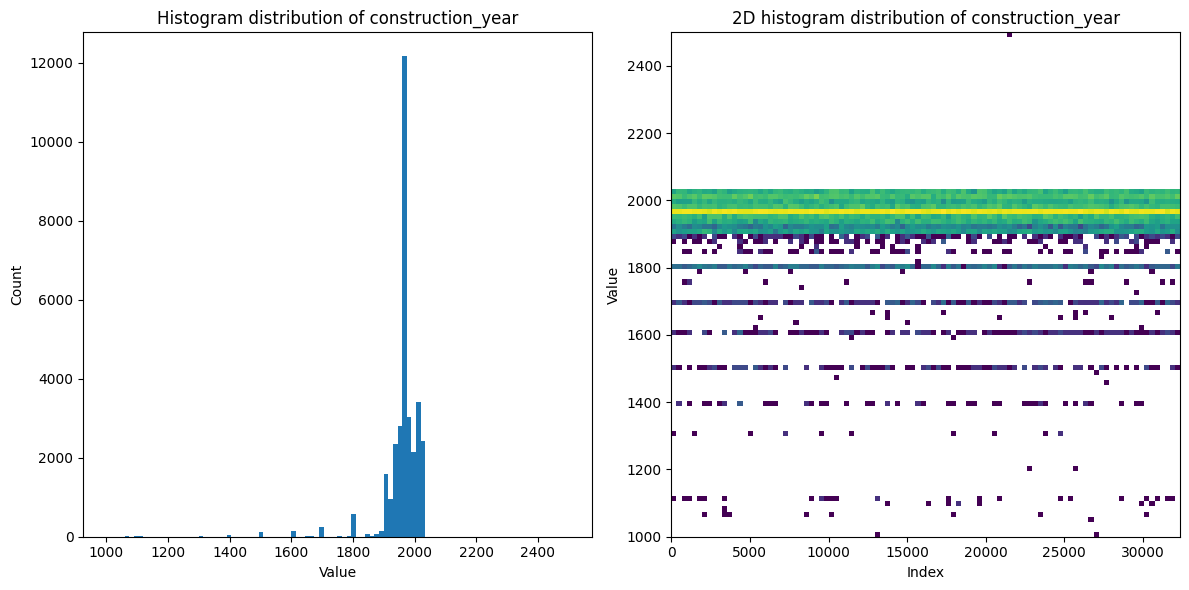

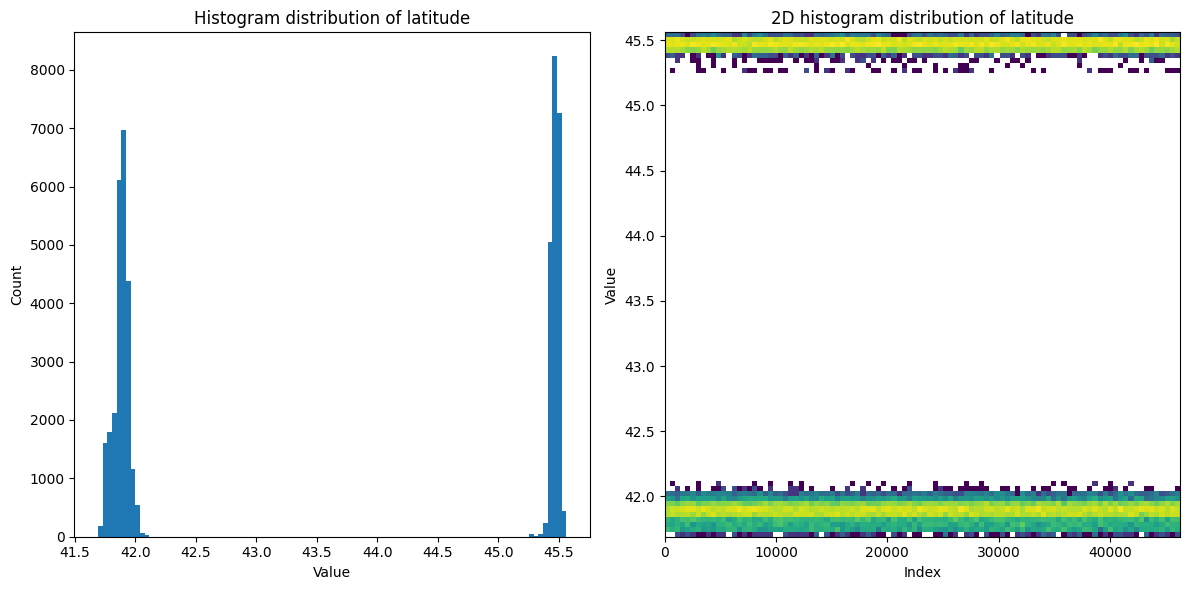

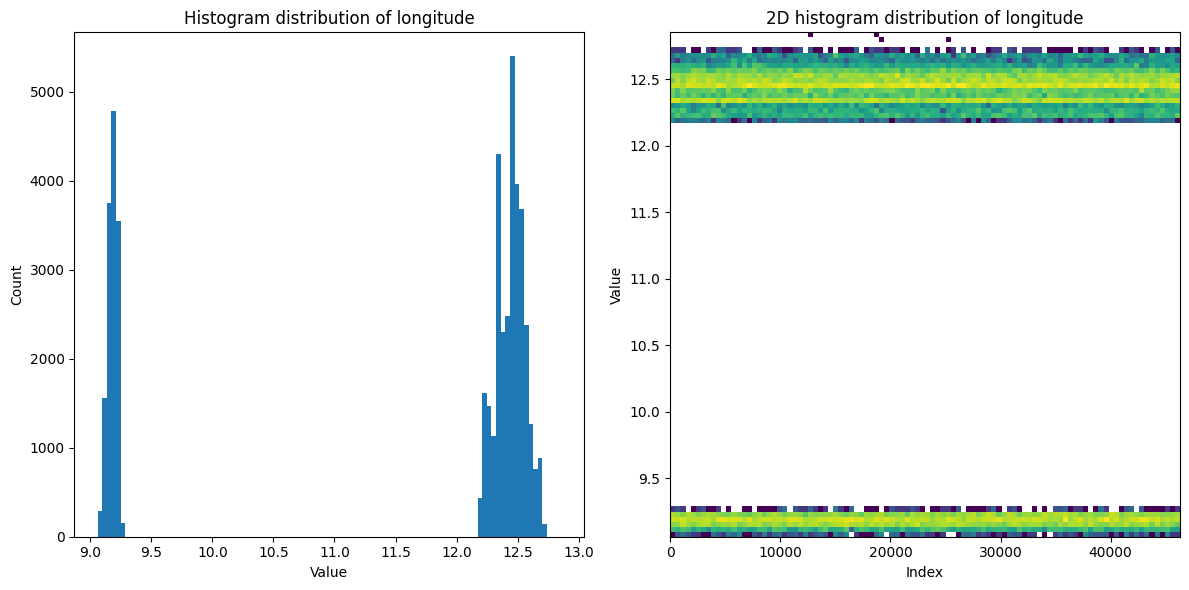

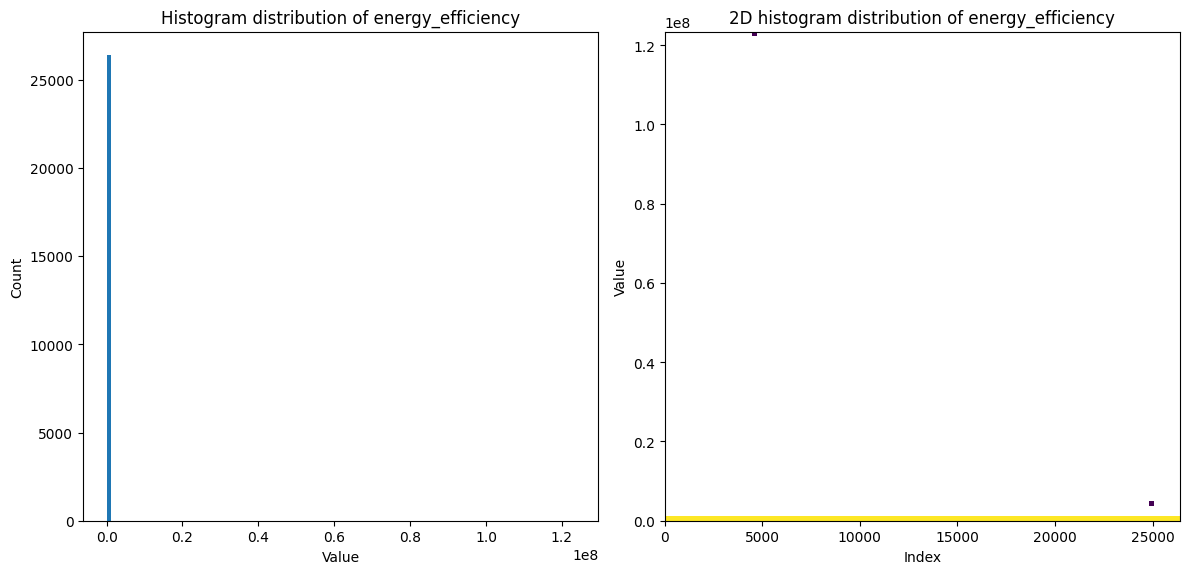

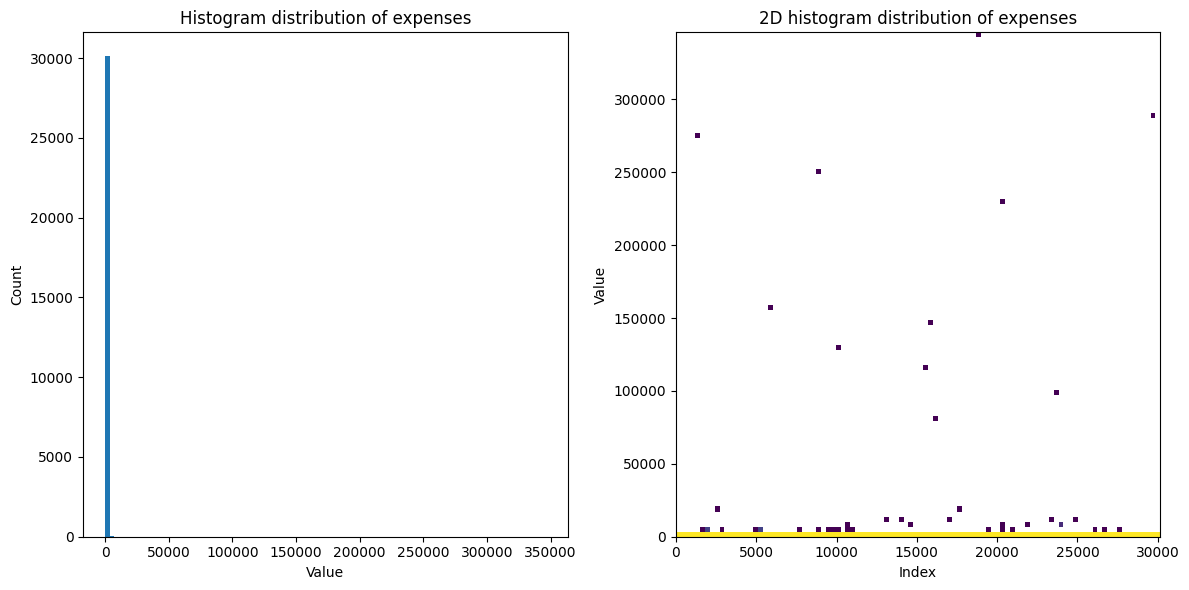

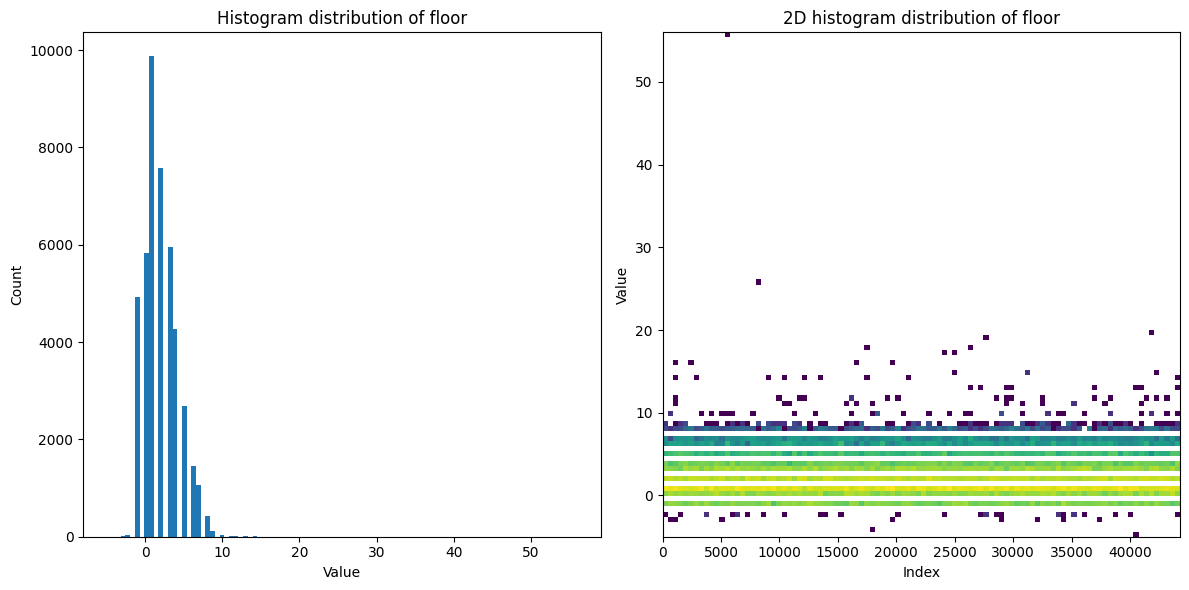

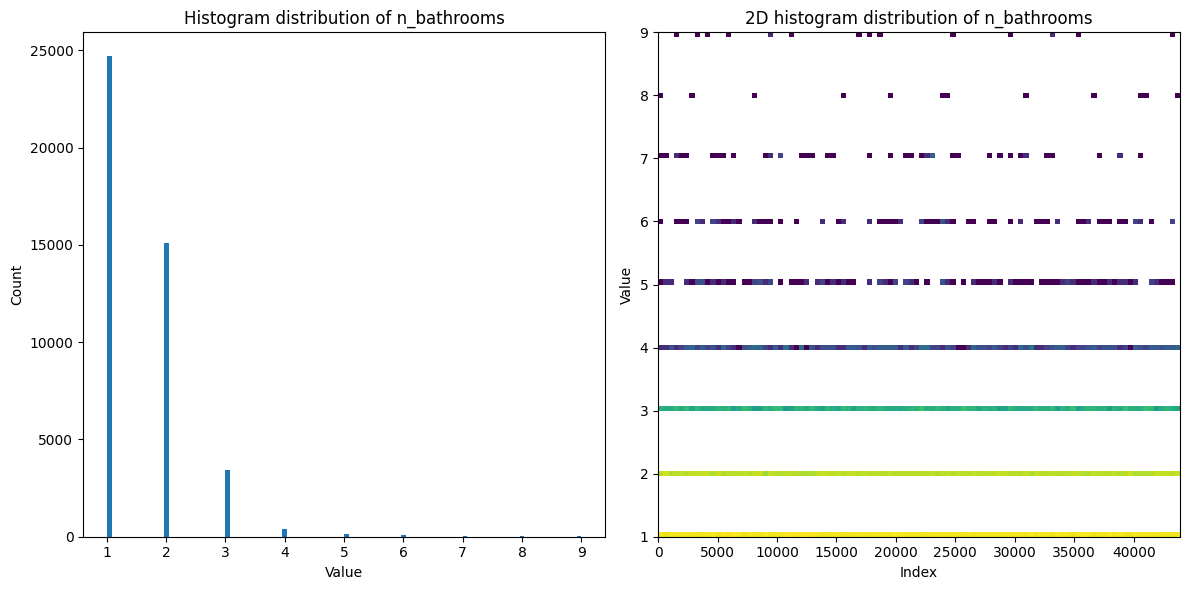

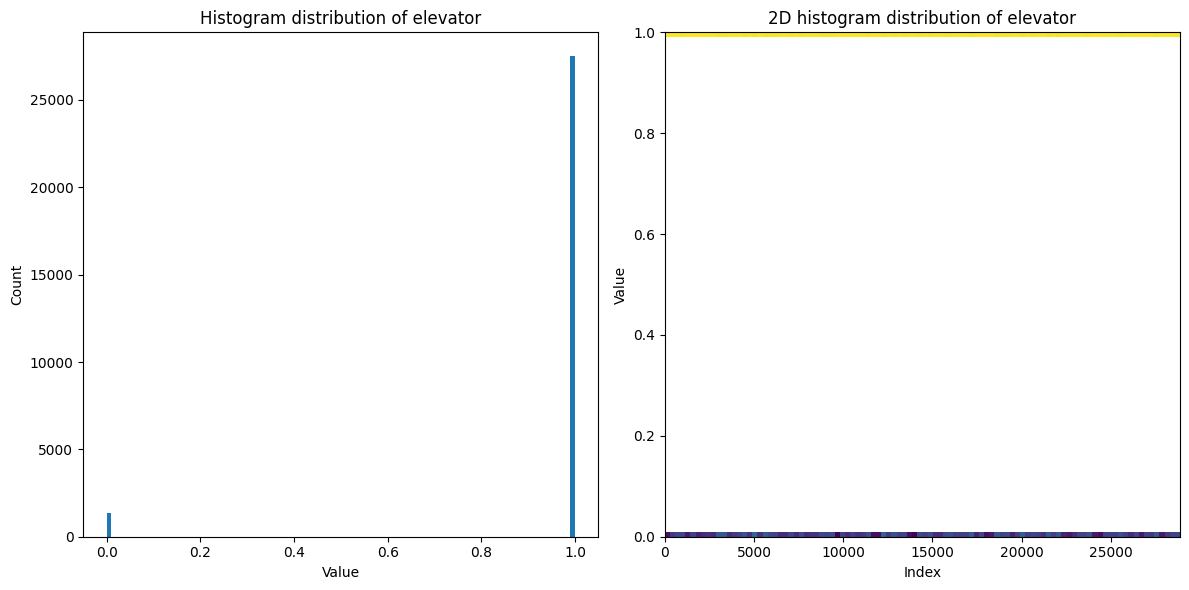

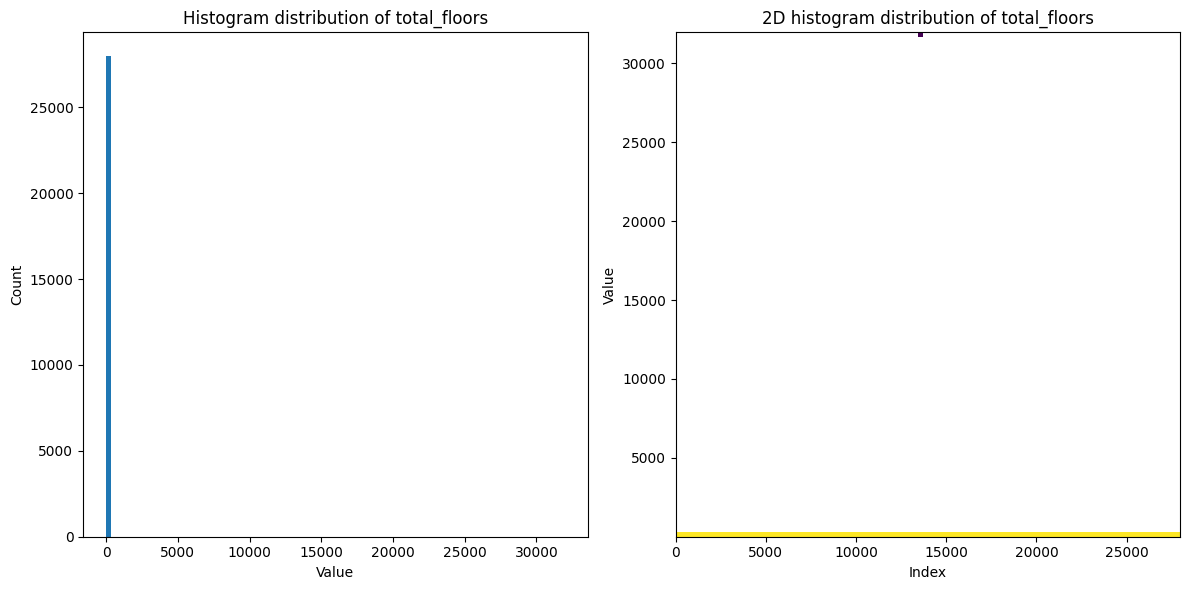

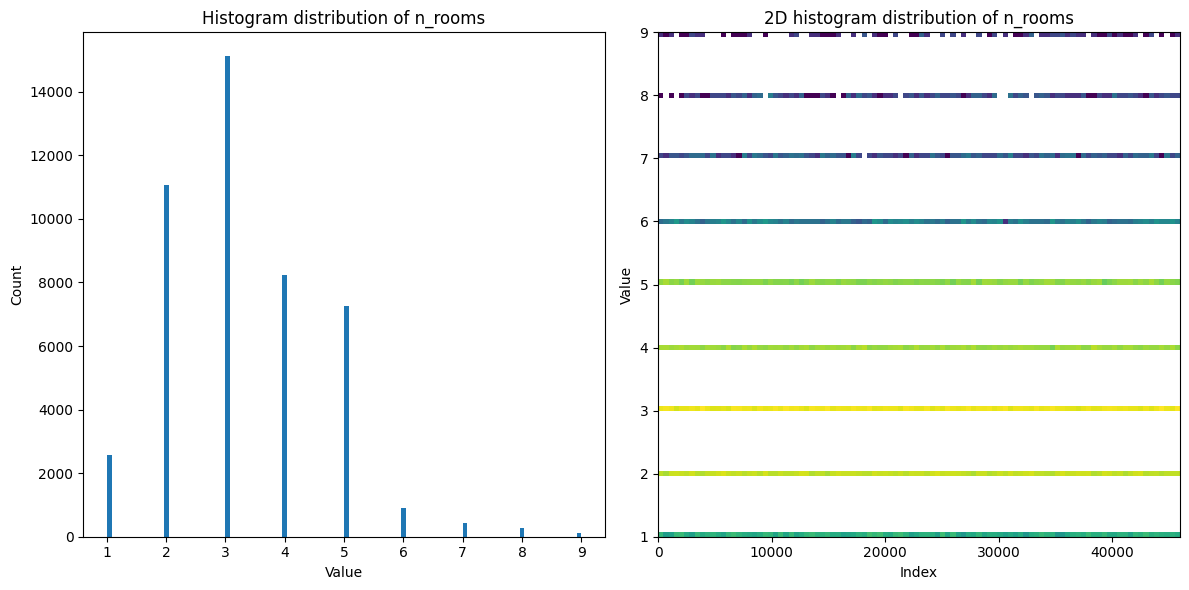

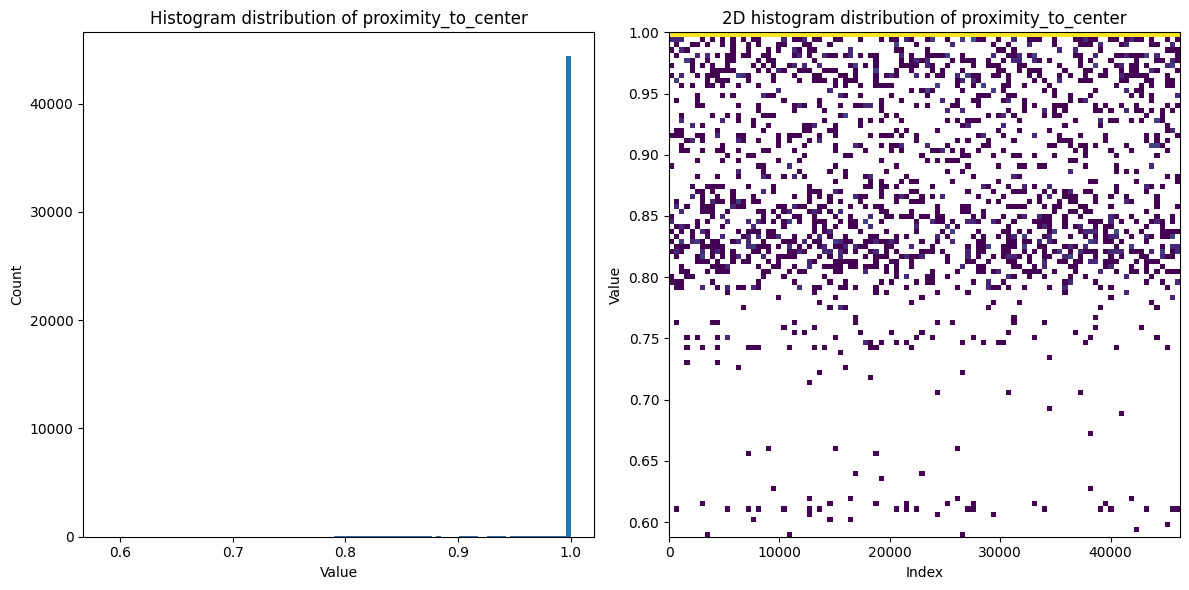

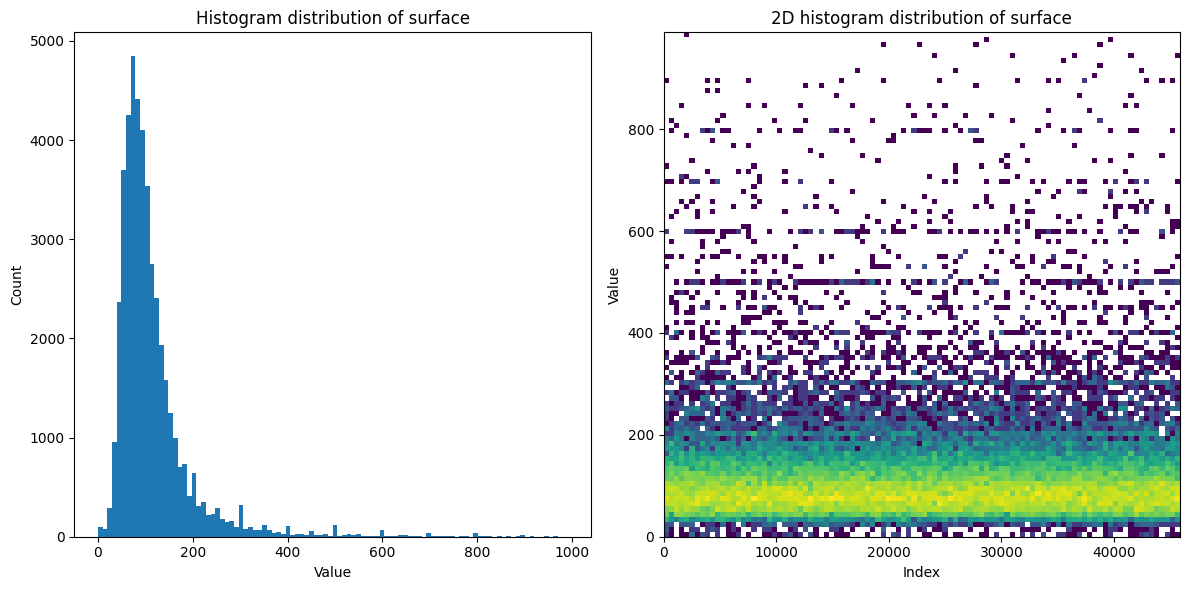

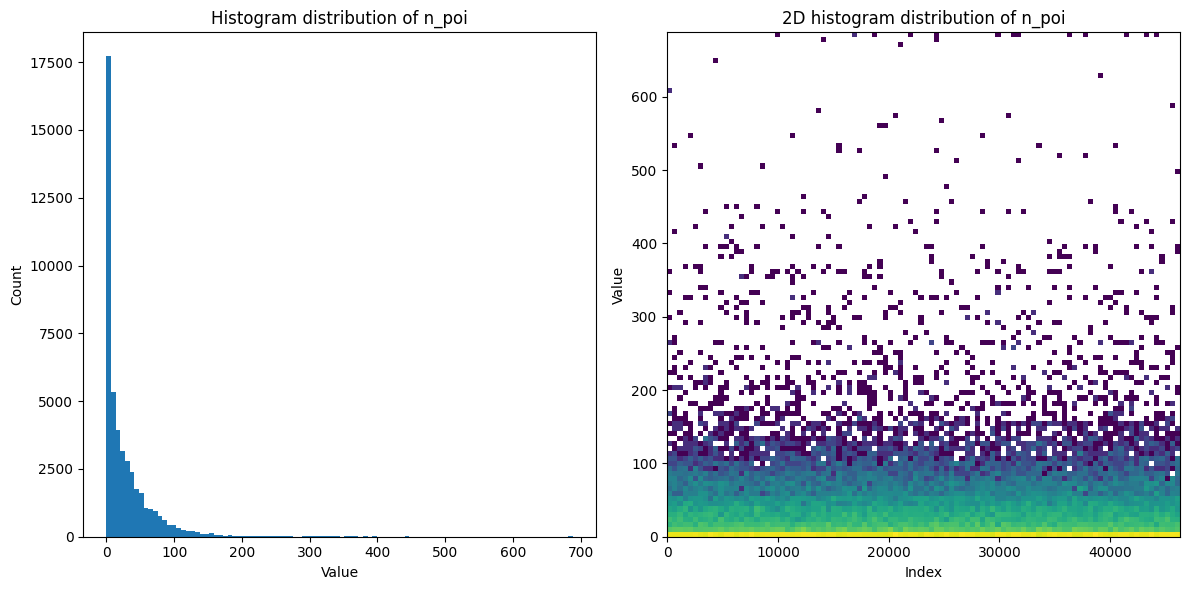

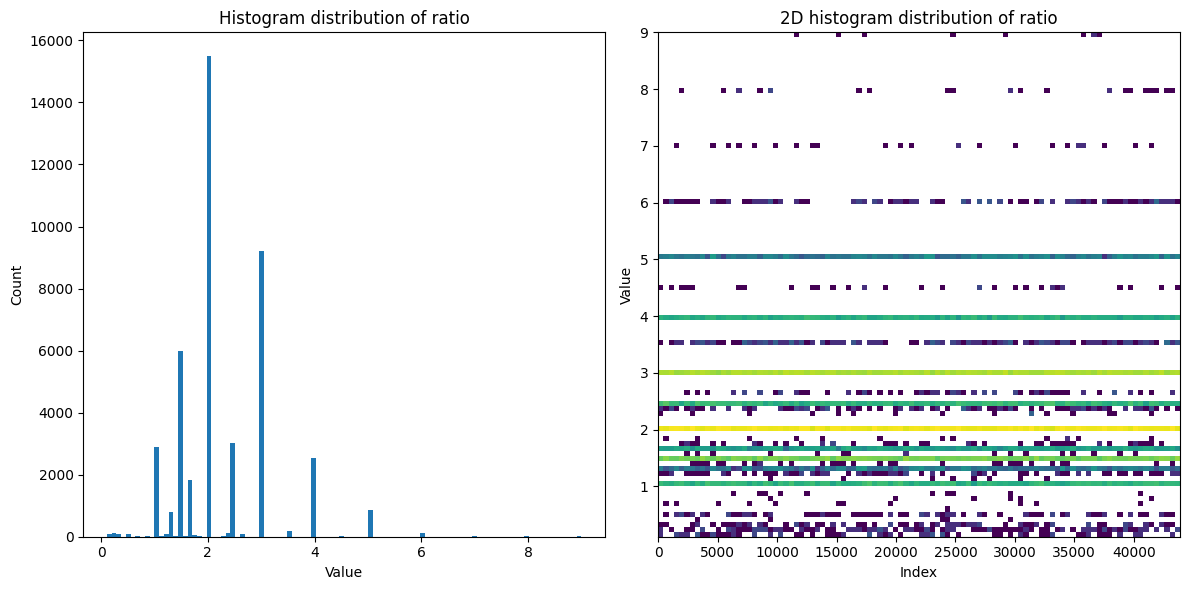

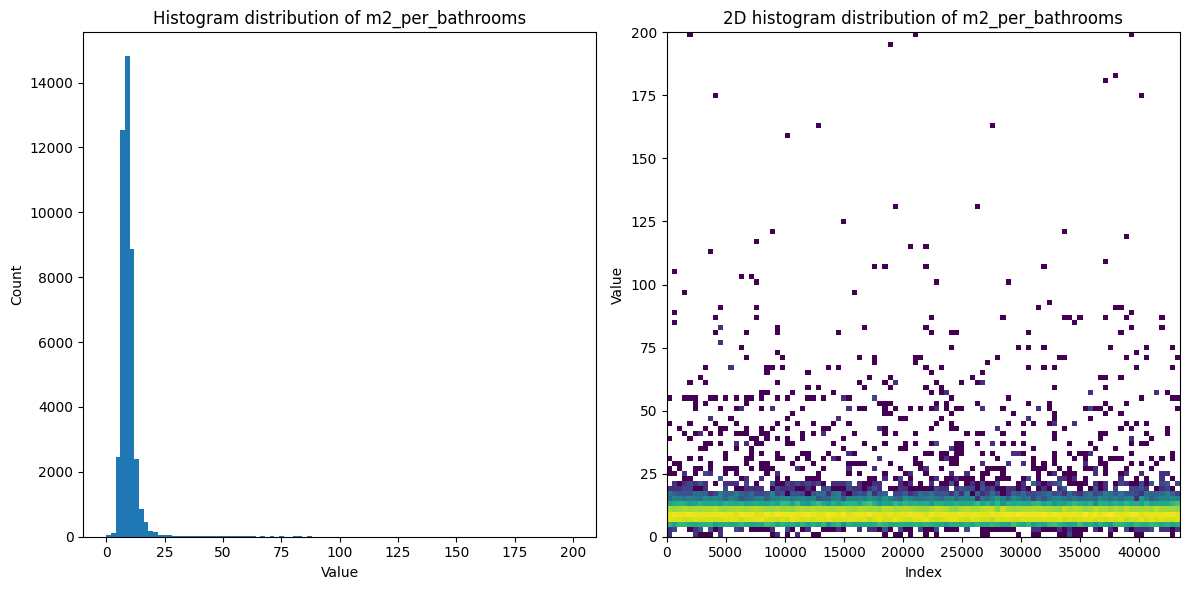

In [32]:
for col in columns_wnan:
    hist_subplot(train_df, col)

Droppiamo pero' le entries che hanno troppi NaN perche' saranno samples molto sintetici dopo aver imputato i valori dei loro NaN.

In [33]:
analysis1, analysis2 = NaN_analysis(train_df)

In [34]:
analysis2

n_nan  n_rows
0      12       1
1      11       4
2      10     188
3       9     146
4       8     172
5       7     264
6       6     925
7       5    3030
8       4    5780
9       3    7580
10      2    7685
11      1    9166
12      0   11371

Droppiamo i samples che hanno 7 o piu' feature NaN 

In [35]:
shape_t0 = train_df.shape[0]
train_df = train_df[train_df.isna().sum(axis=1) < 7]
shape_t1 = train_df.shape[0]

In [36]:
print('shape before removing features with many NaNs: {}'.format(shape_t0))
print('shape after removing features with many NaNs: {}'.format(shape_t1))
print('shape difference: {}'.format(shape_t0-shape_t1))
print('percentage of removed rows: {}%'.format(round((shape_t0-shape_t1)*100/shape_t0, 2)))

shape before removing features with many NaNs: 46312
shape after removing features with many NaNs: 45537
shape difference: 775
percentage of removed rows: 1.67%


# 2. Data Processing

In questa sezione processiamo i dati per poter procedere poi al training dei modelli. L'obiettivo in questa sezione è di processare al meglio i dati per renderli al meglio digeribili dai supervised models

# 2.1. Data Transformation

PLottiamo prima delle trasformation, gli hist per ogni colonna di train_df

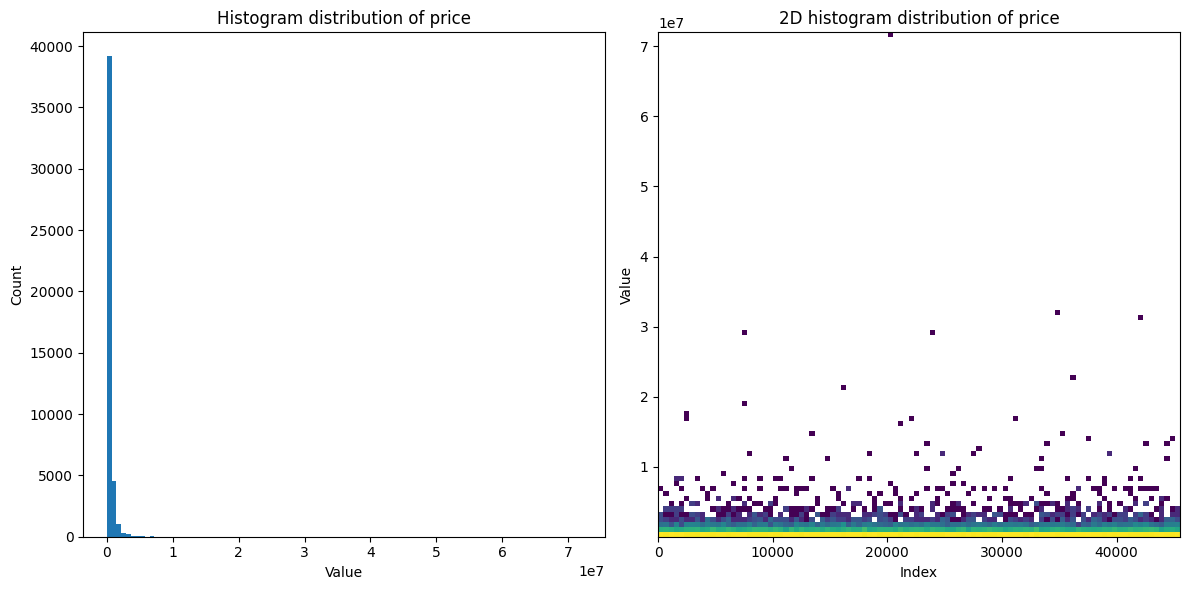

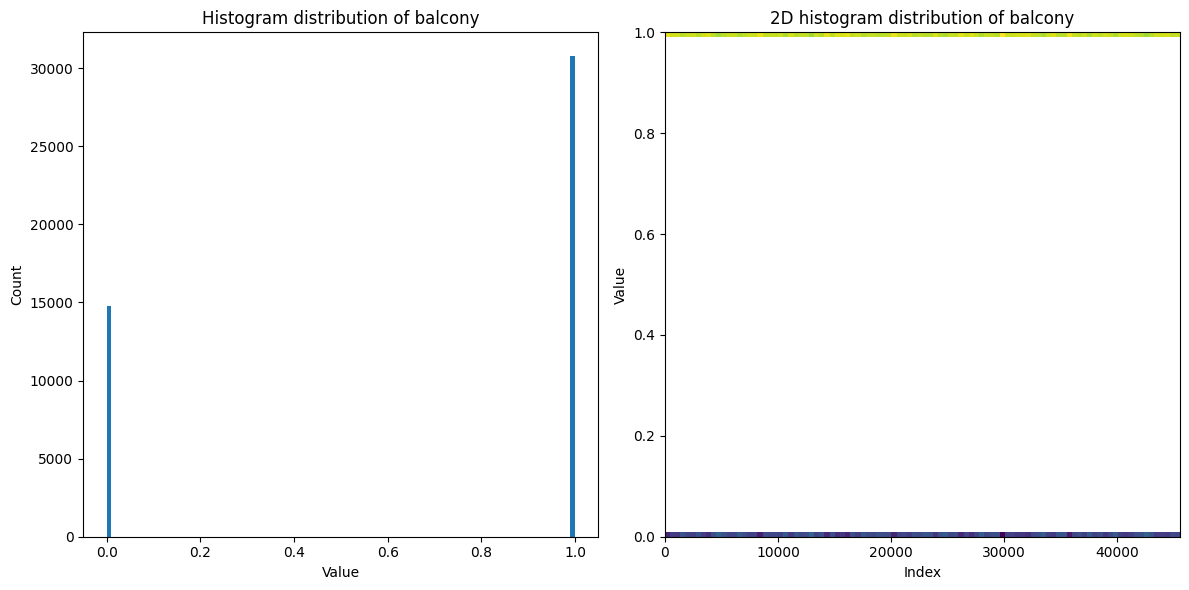

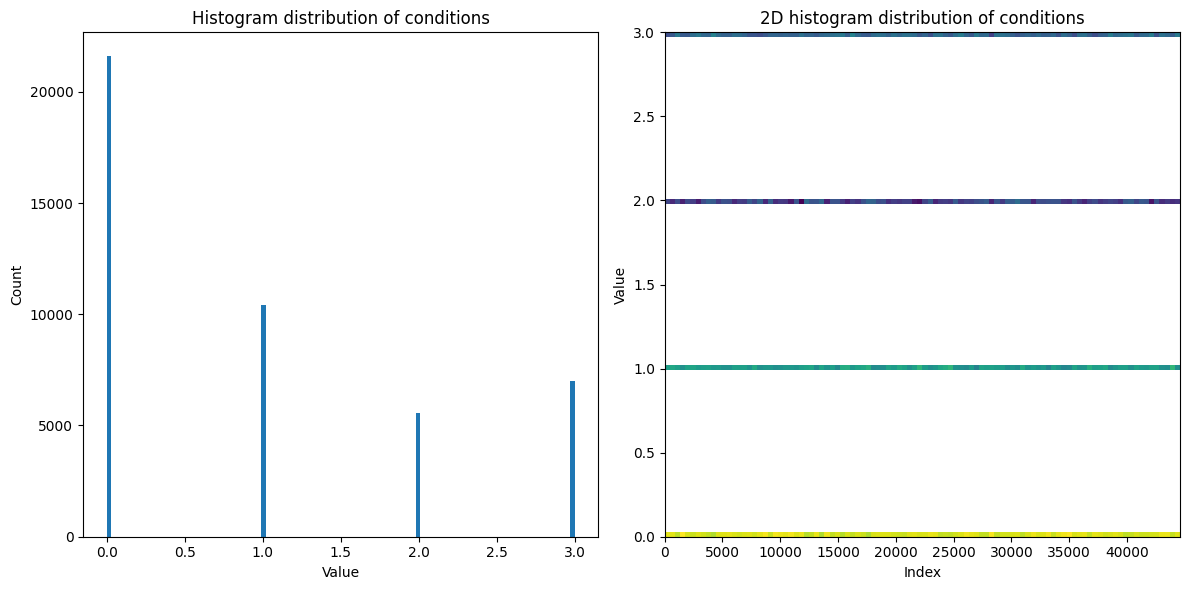

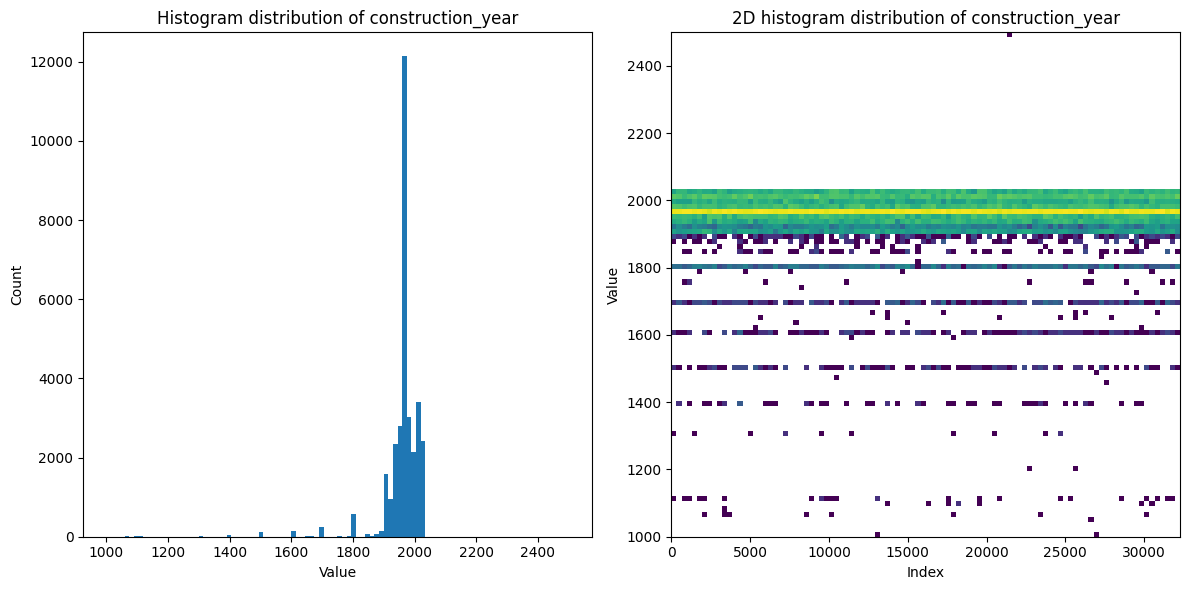

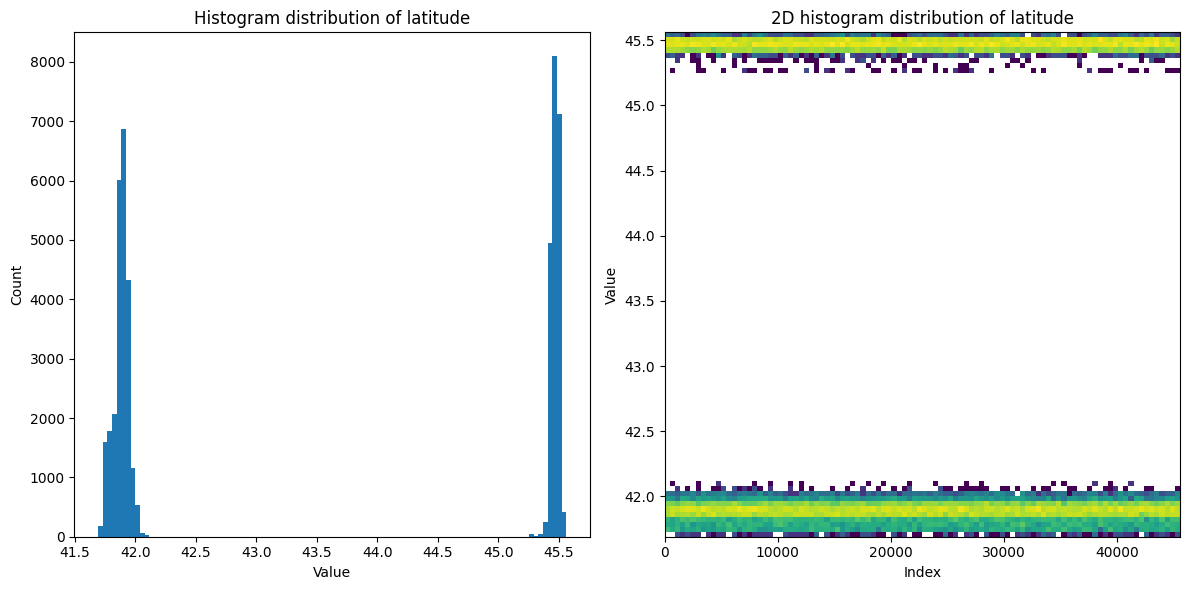

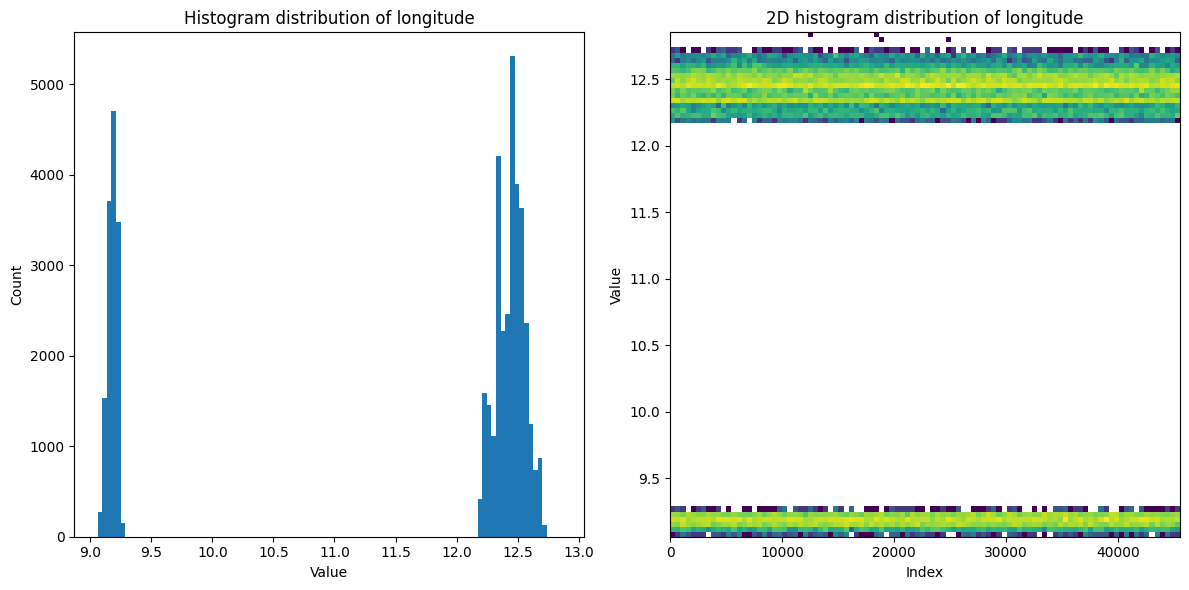

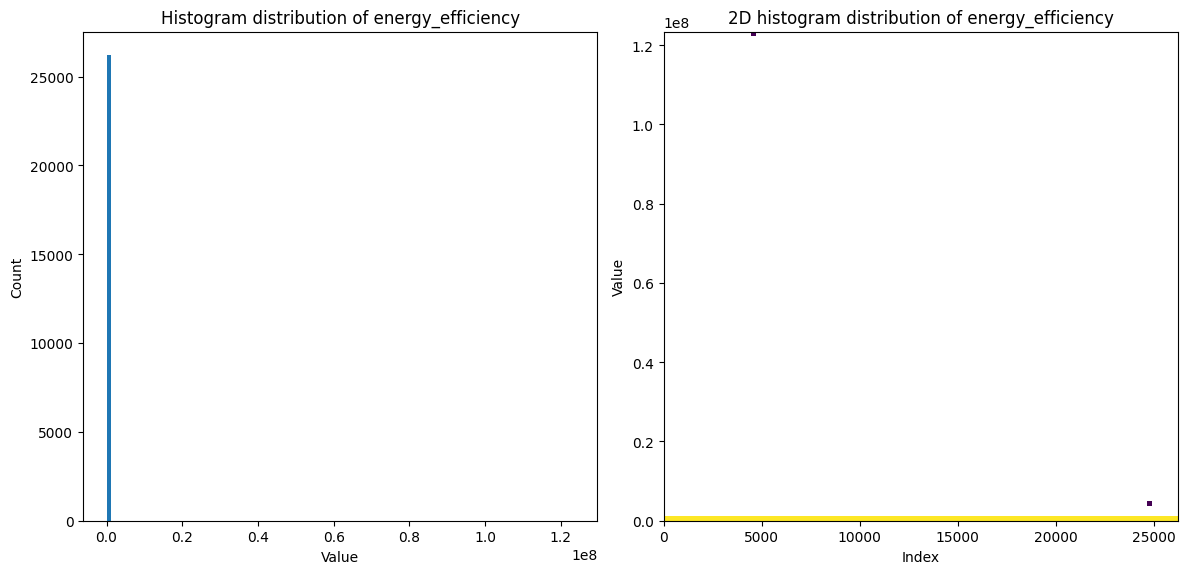

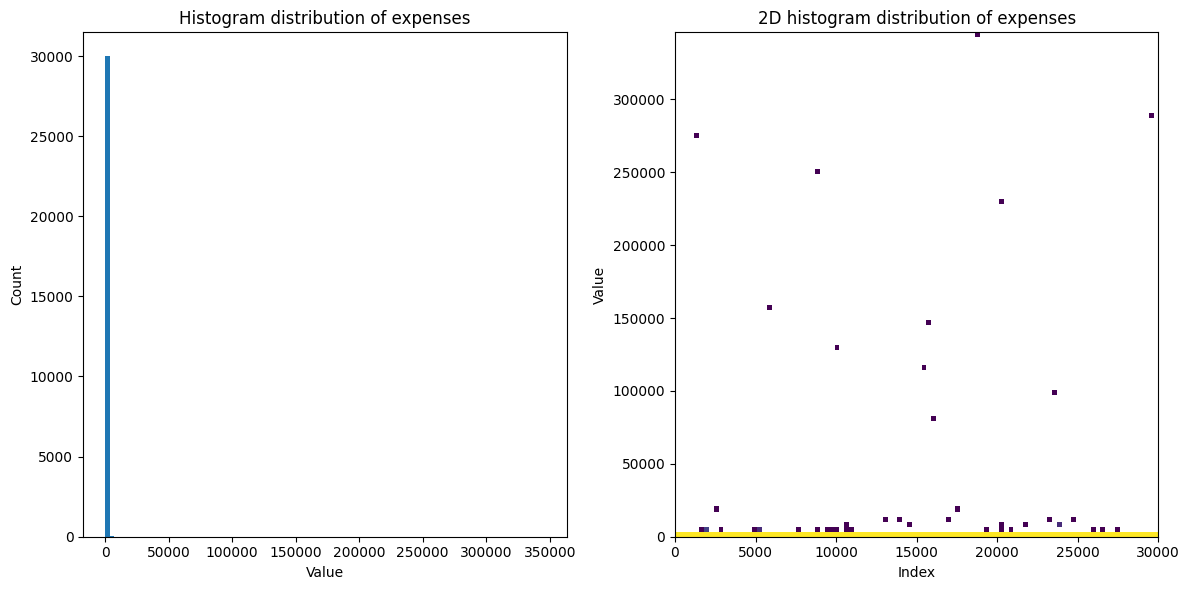

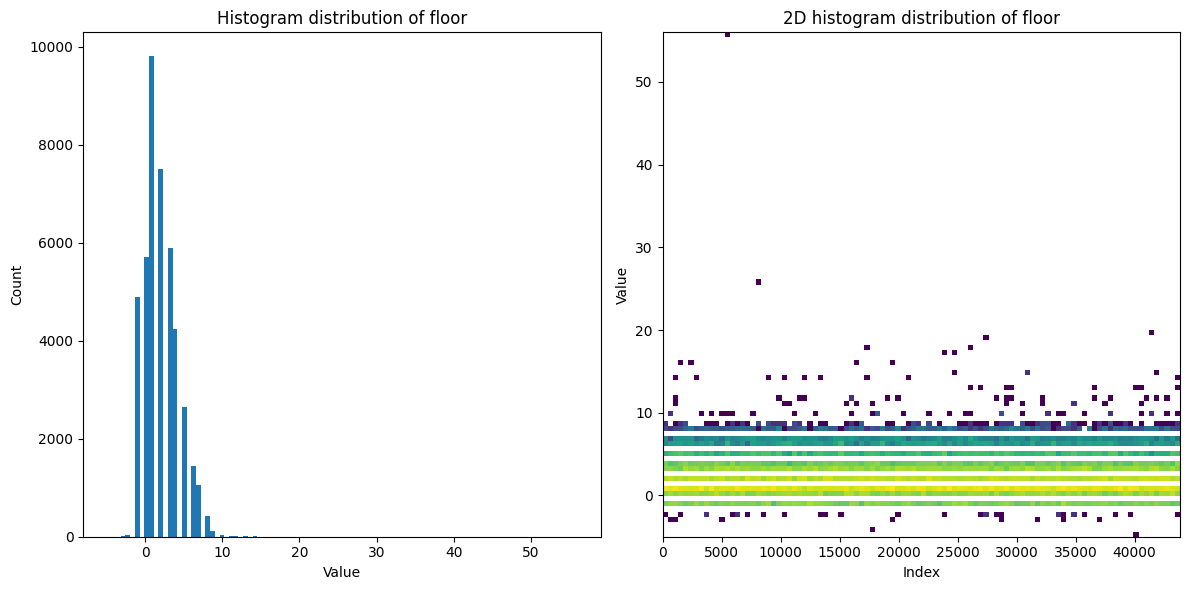

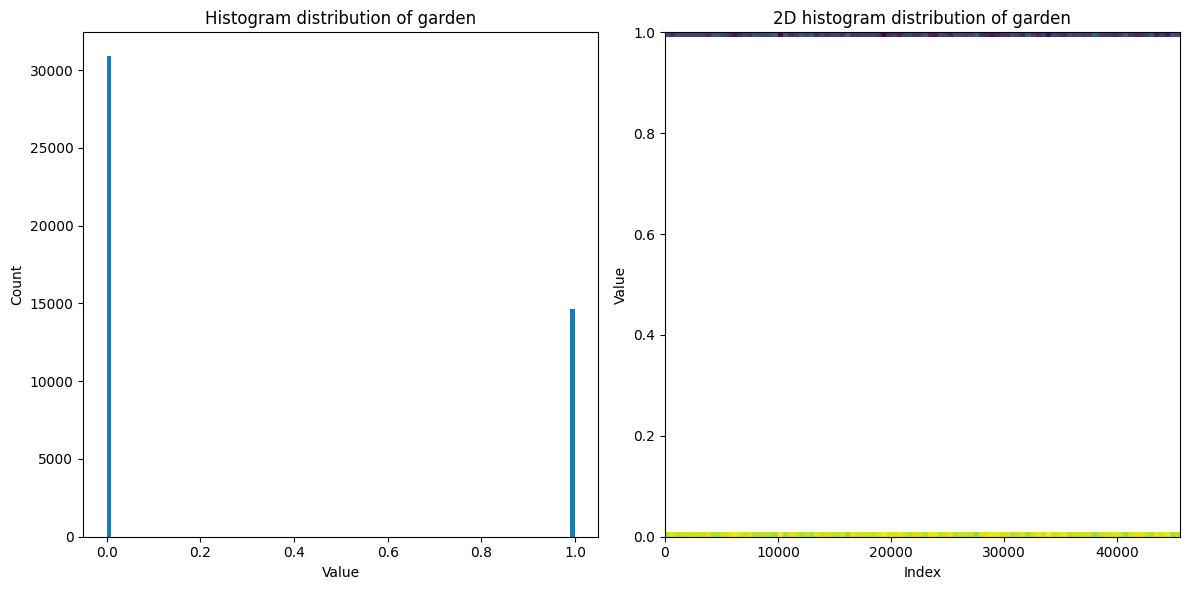

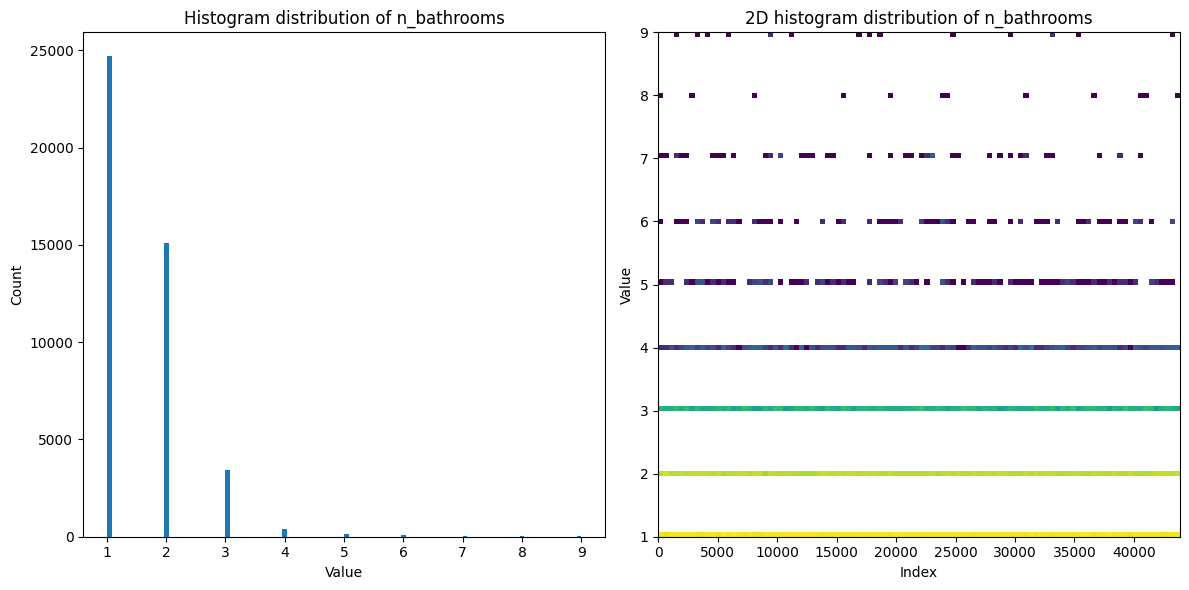

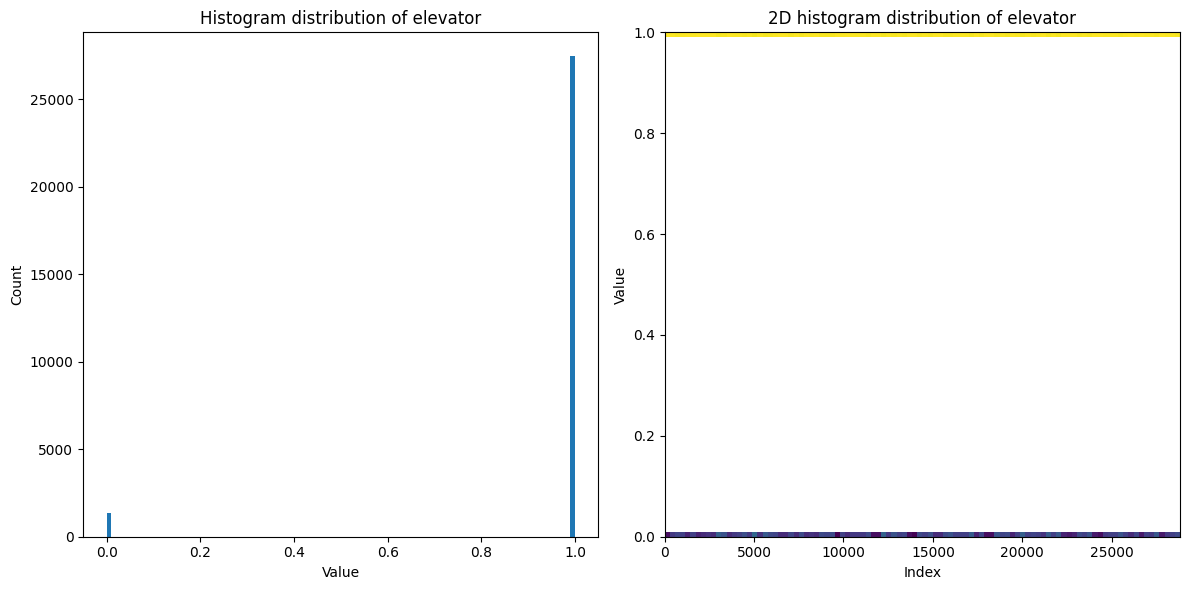

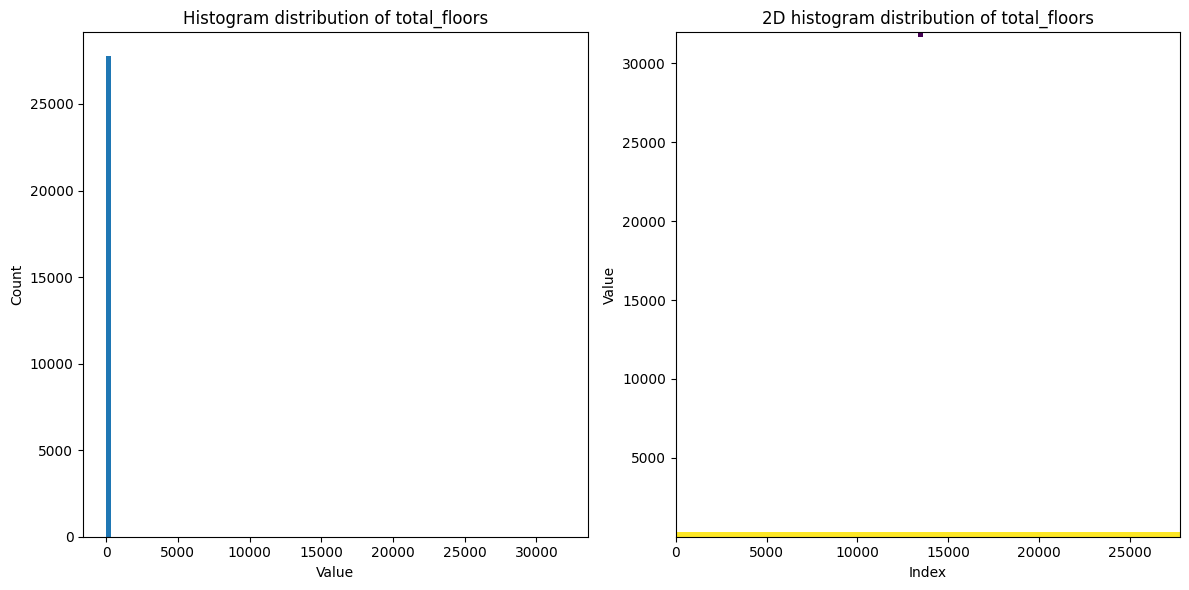

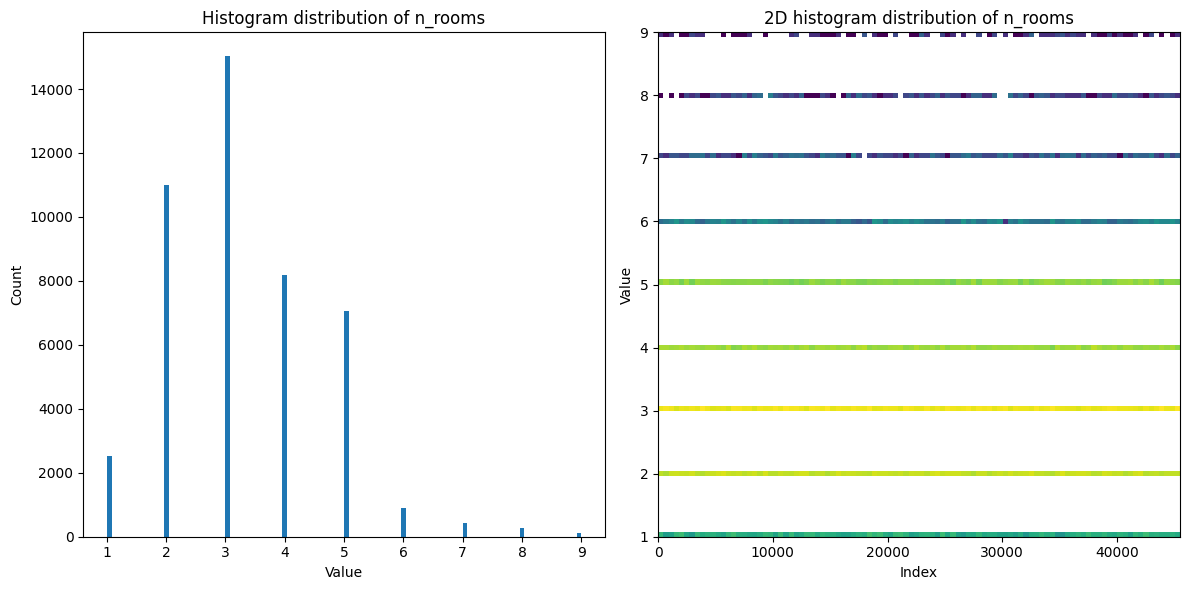

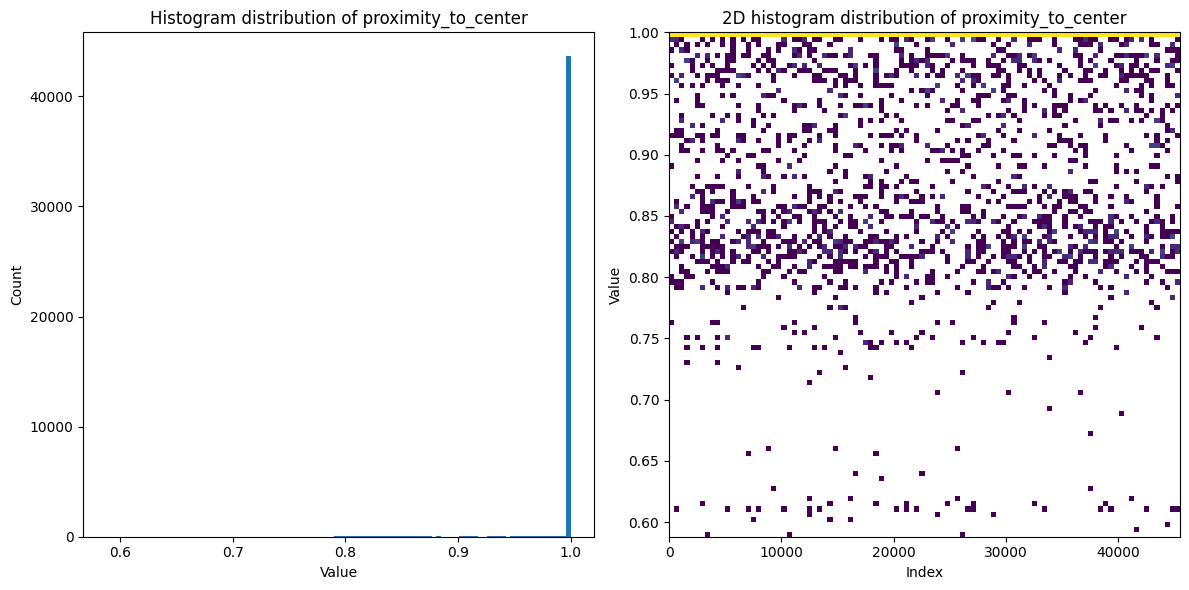

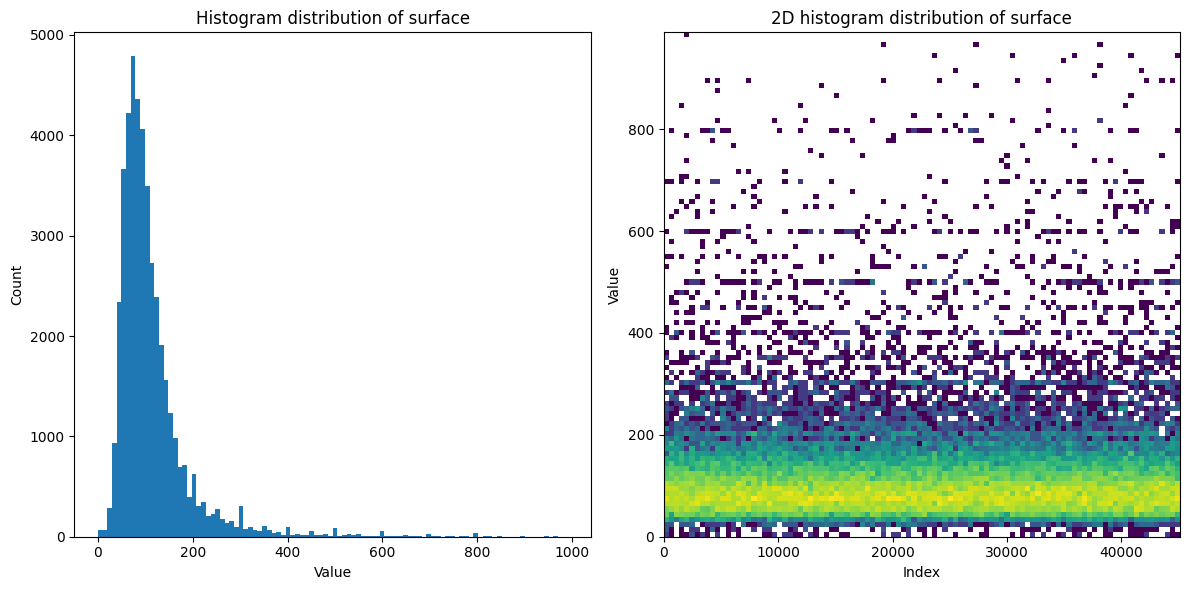

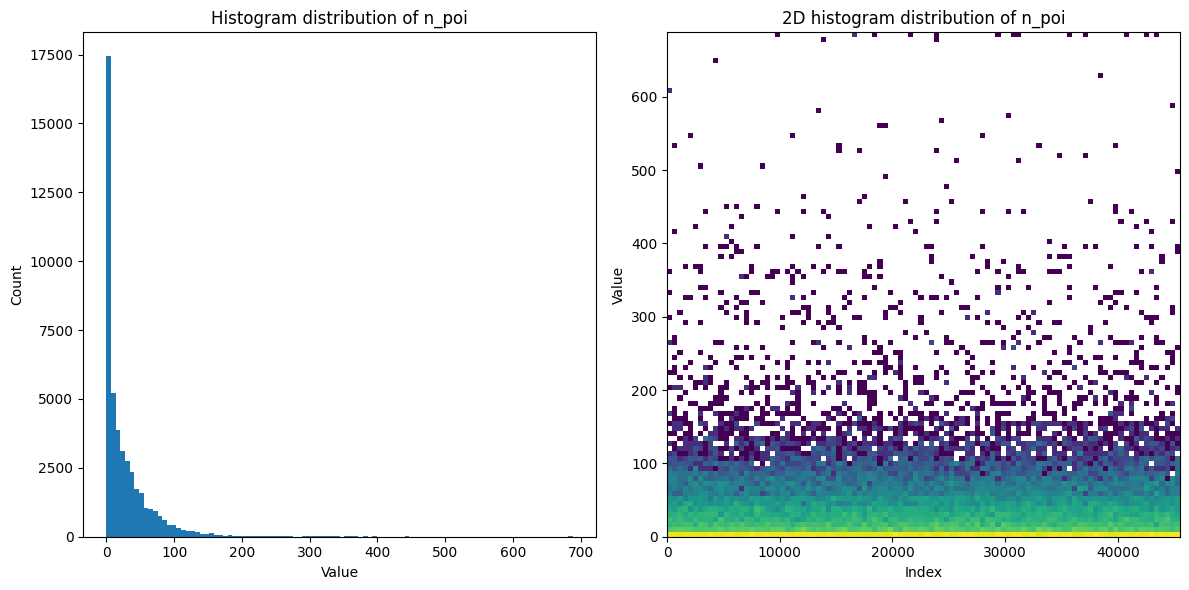

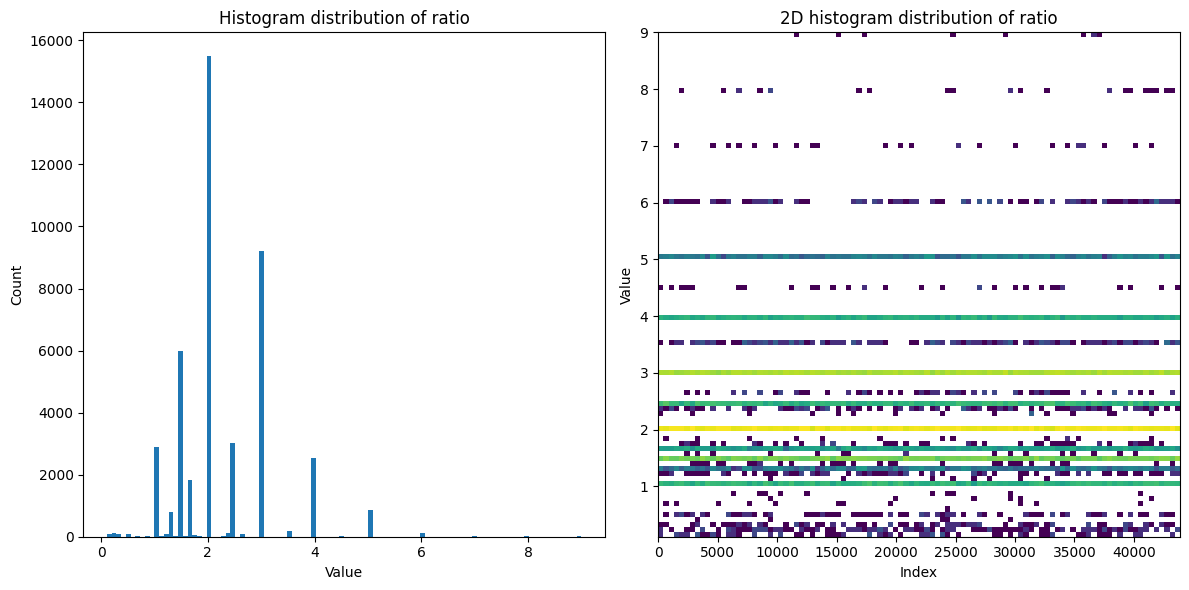

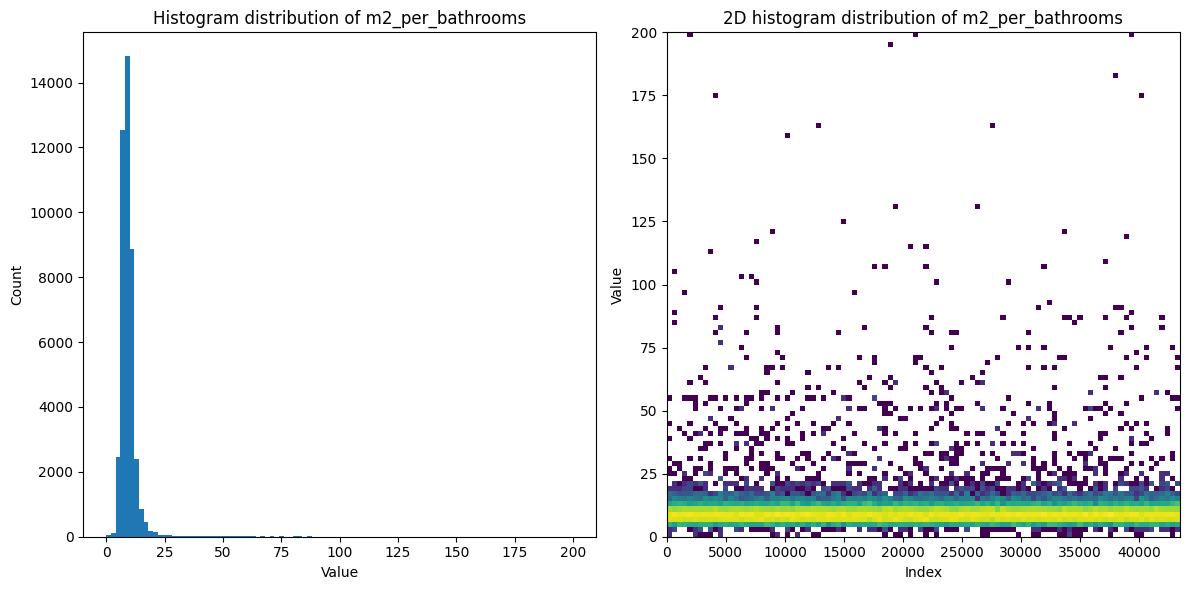

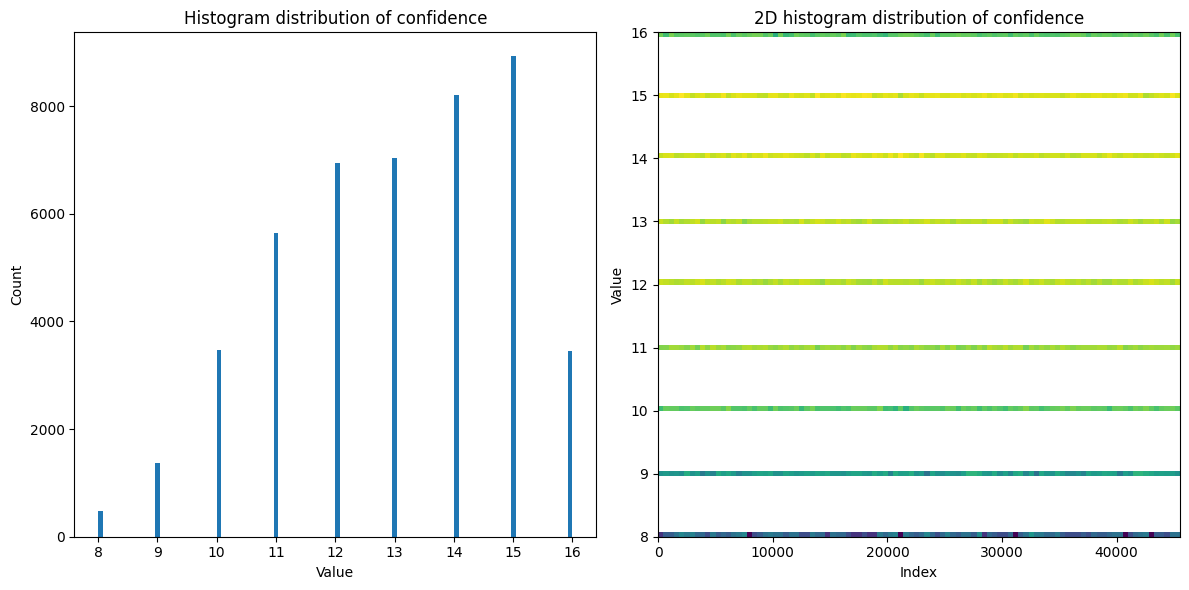

In [37]:
for col in train_df.columns:
    hist_subplot(train_df, col)

separiamo le features dalle prediction per performare nel migliore dei modi: StandardScaler, KNNImputer, Normalizer

In [38]:
x_train = train_df.drop('price', axis=1)
y_train = train_df['price']

scaliamo tutti i dati

In [39]:
x_scaler = StandardScaler()
x_train = pd.DataFrame(x_scaler.fit_transform(x_train), columns=x_train.columns)
y_scaler = StandardScaler()
y_train = pd.DataFrame(y_scaler.fit_transform(y_train.values.reshape(-1, 1)), columns=['price'])

Moving our attention to the KNNImputer, it will fill the NaNs using the mean value from the 5 nearest neighbors of each NaN found in the training set for each feature considered. 

In [40]:
x_imputer = KNNImputer()
x_train = pd.DataFrame(x_imputer.fit_transform(x_train), columns=x_train.columns)

normalizziamo le features

In [41]:
x_normalizer = Normalizer()
x_train = pd.DataFrame(x_normalizer.fit_transform(x_train), columns=x_train.columns)

In [42]:
train_df = pd.concat([x_train, y_train], axis=1)

We run again the NaN analysis to verify that there are no more NaNs in any feature. 

In [43]:
analysis1, analysis2 = NaN_analysis(train_df)

In [44]:
analysis1

column  n_nan  percentage
0               balcony      0         0.0
1            conditions      0         0.0
2            confidence      0         0.0
3      m2_per_bathrooms      0         0.0
4                 ratio      0         0.0
5                 n_poi      0         0.0
6               surface      0         0.0
7   proximity_to_center      0         0.0
8               n_rooms      0         0.0
9          total_floors      0         0.0
10             elevator      0         0.0
11          n_bathrooms      0         0.0
12               garden      0         0.0
13                floor      0         0.0
14             expenses      0         0.0
15    energy_efficiency      0         0.0
16            longitude      0         0.0
17             latitude      0         0.0
18    construction_year      0         0.0
19                price      0         0.0

In [45]:
analysis2

n_nan  n_rows
0      0   45537

PLottiamo a fine di tutte le trasformation gli hist di tutte le colonne di train_df

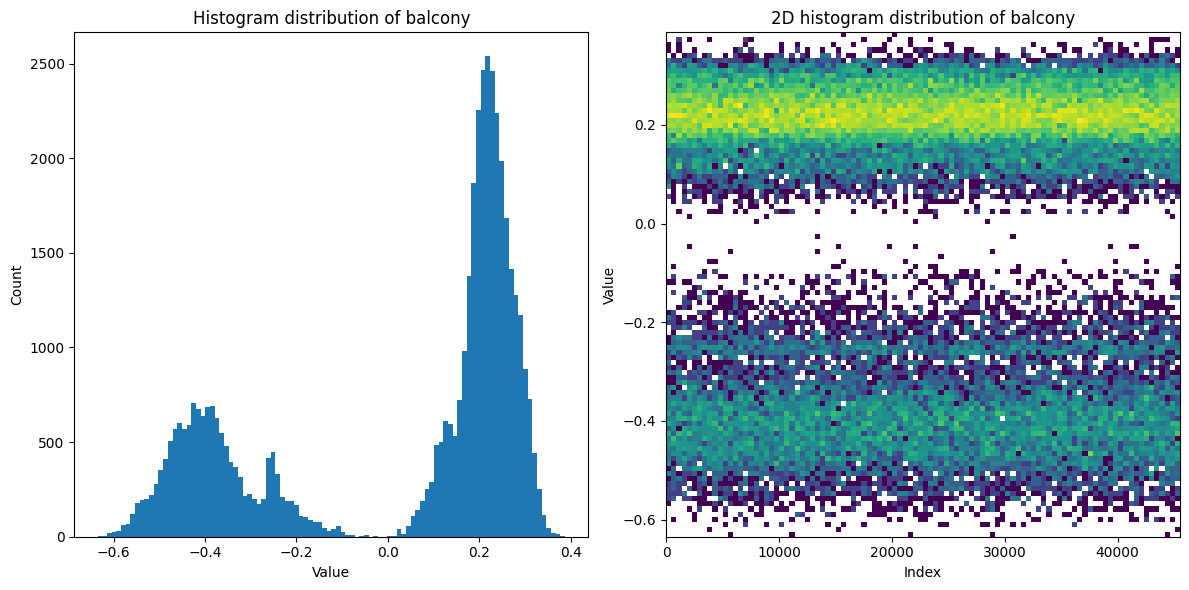

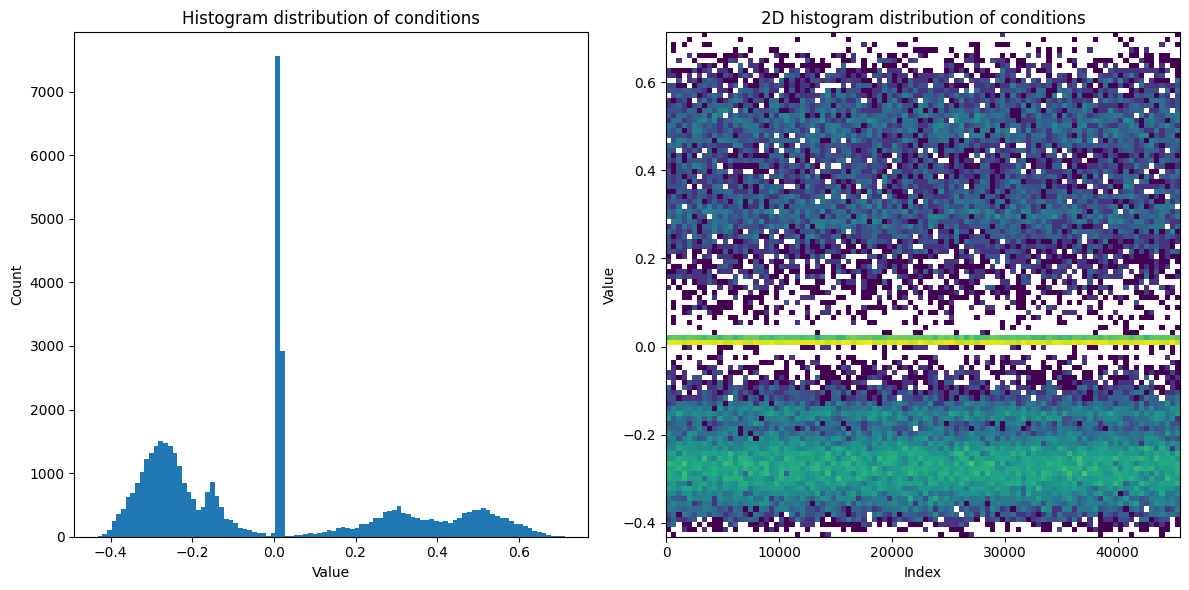

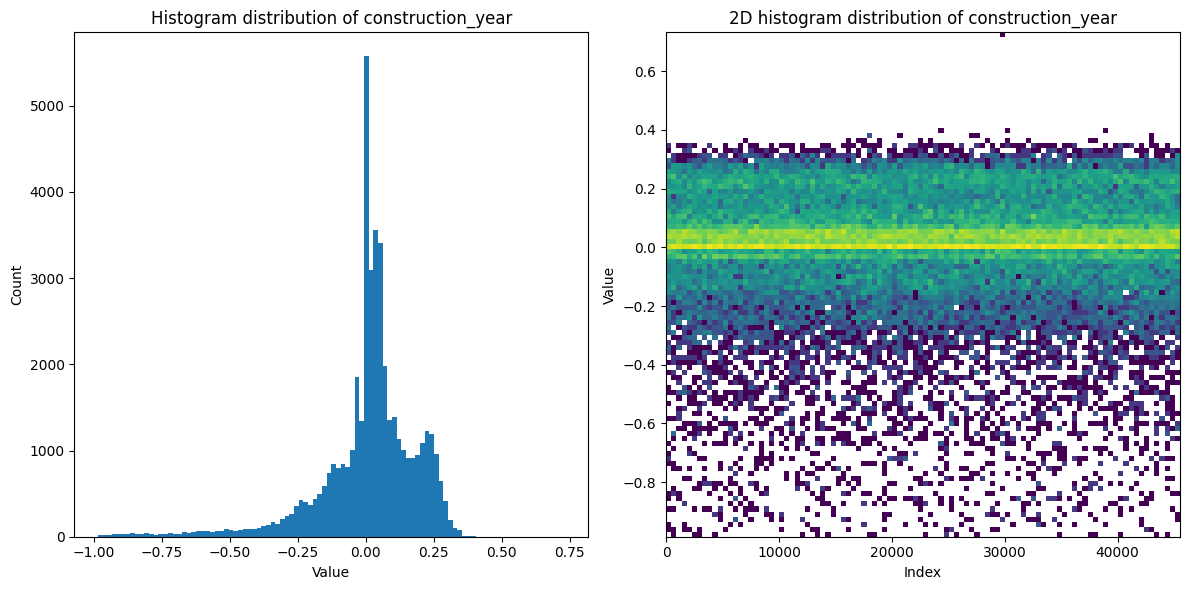

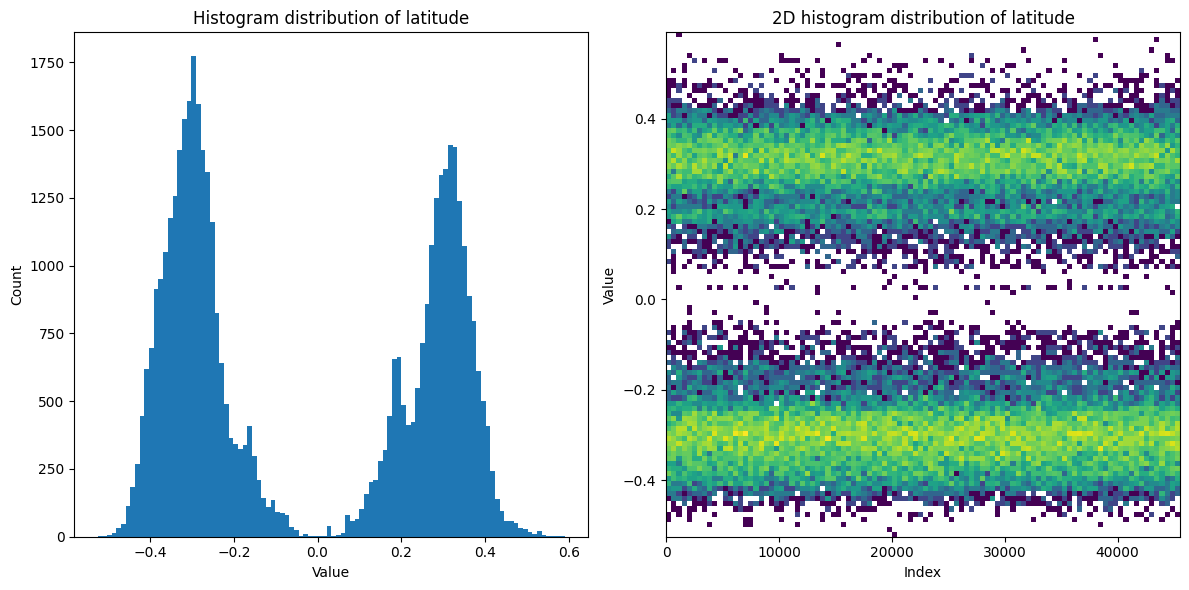

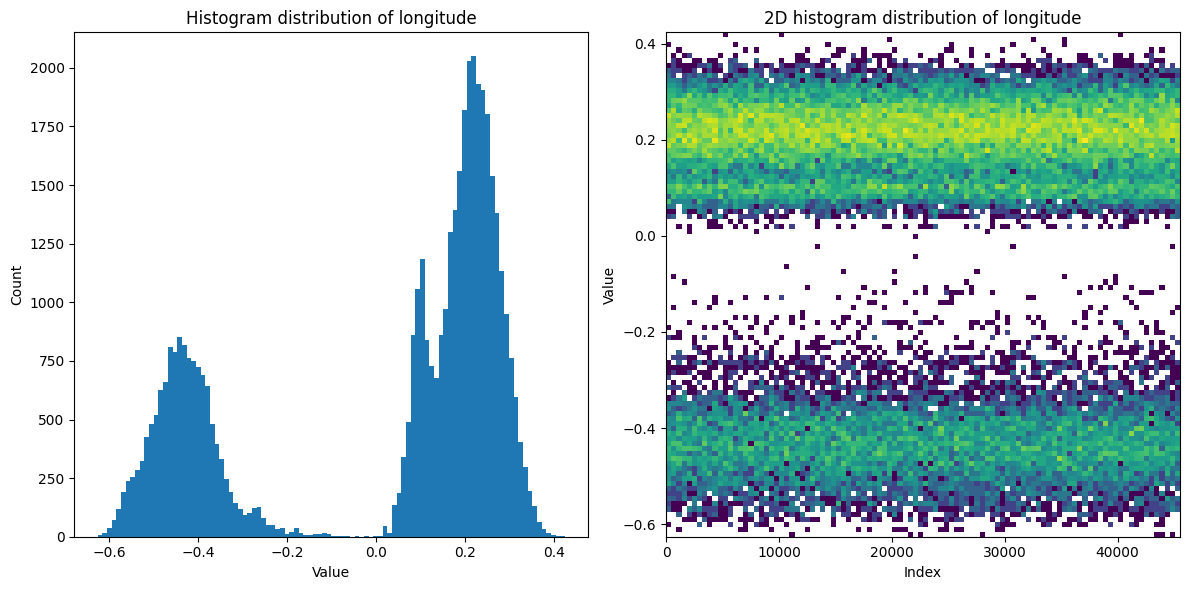

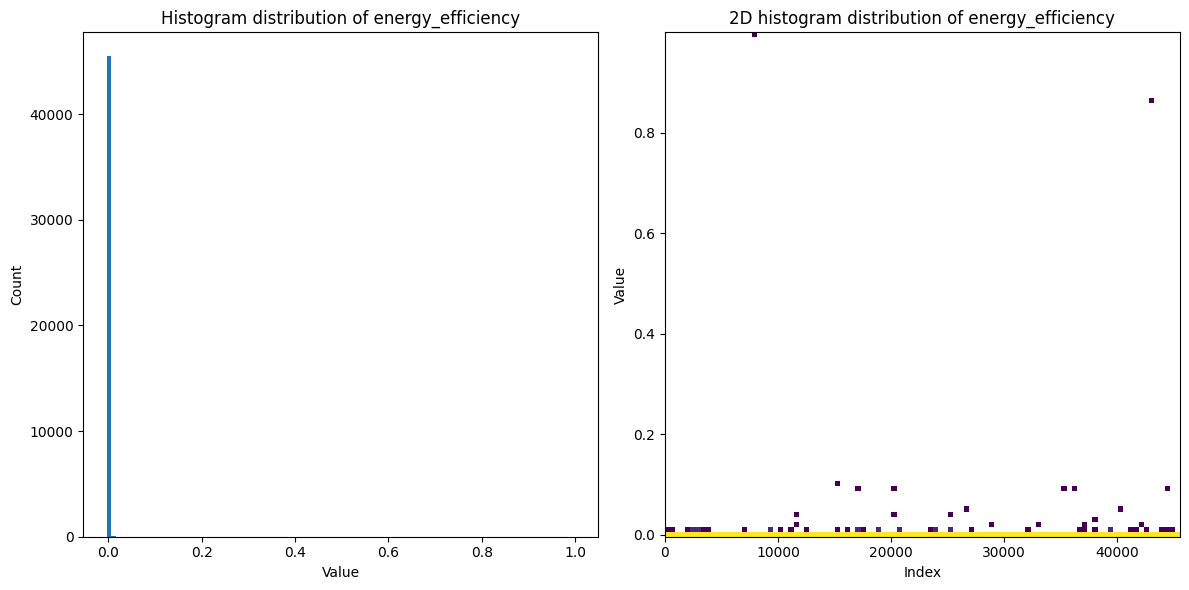

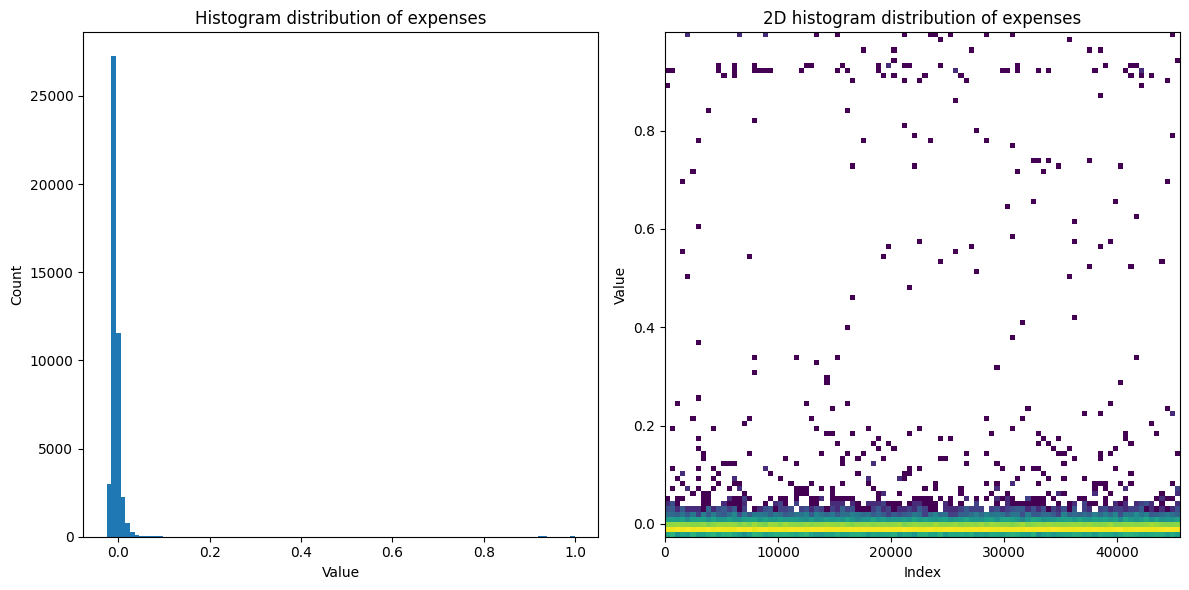

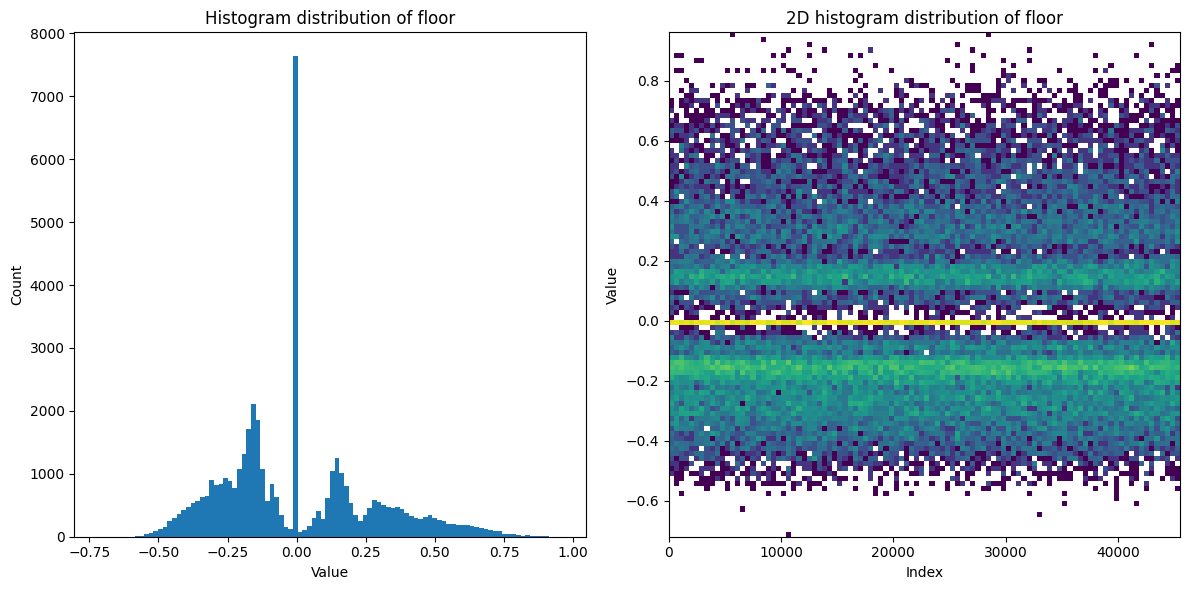

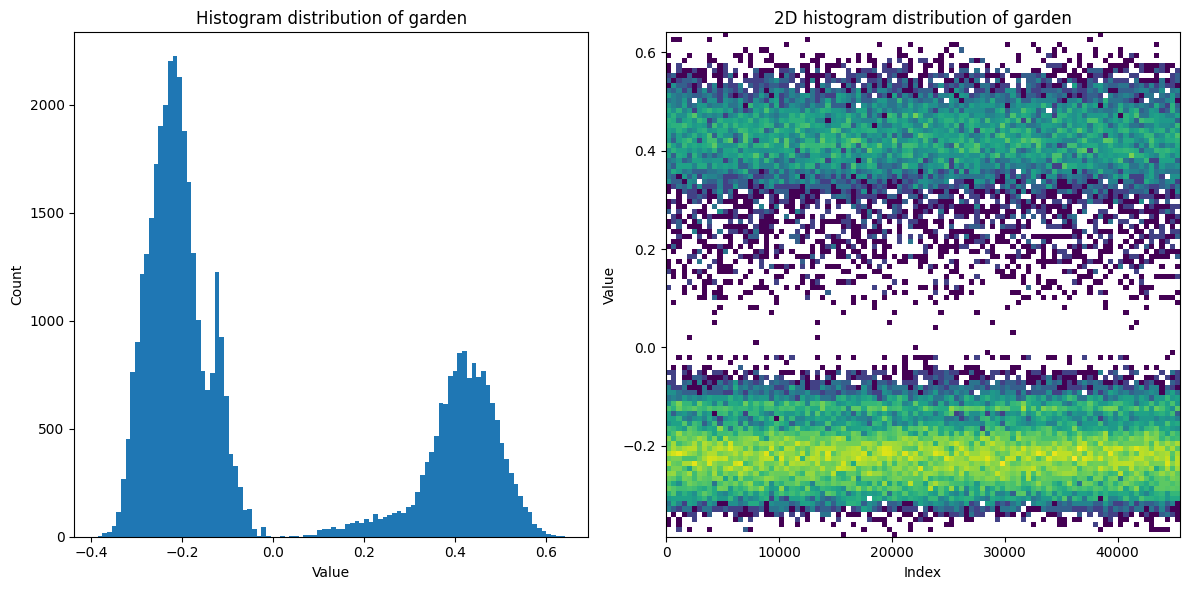

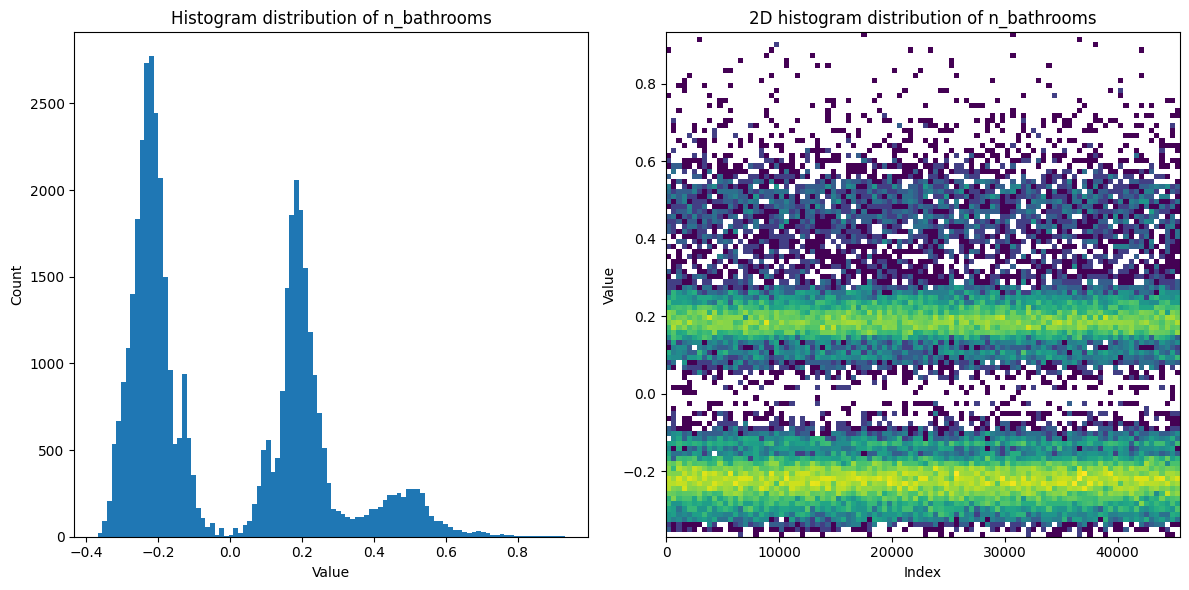

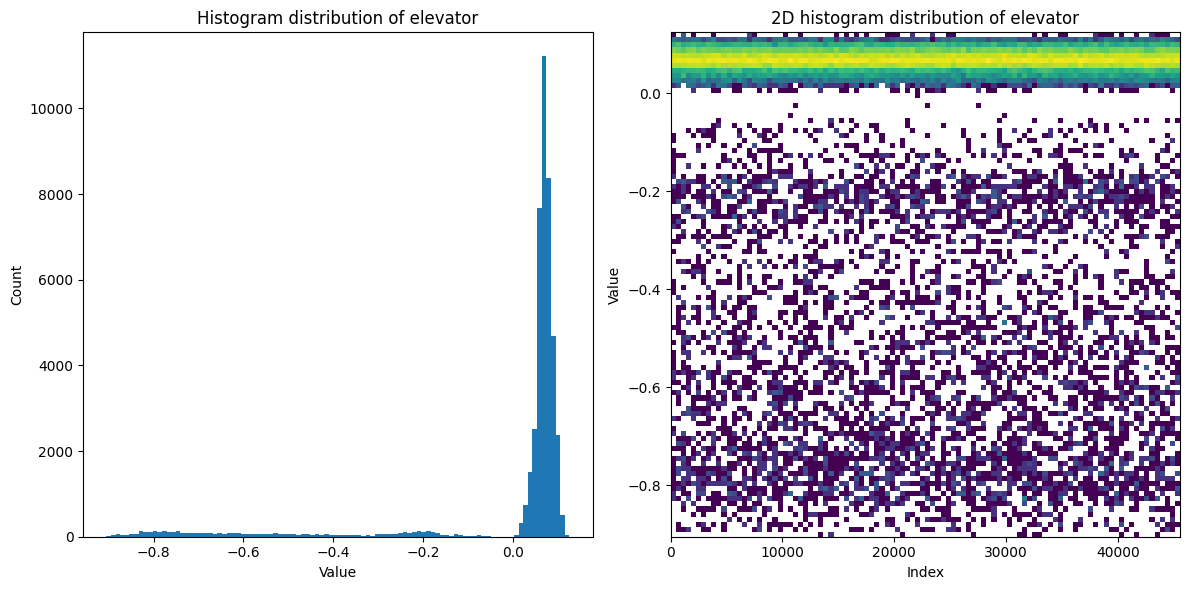

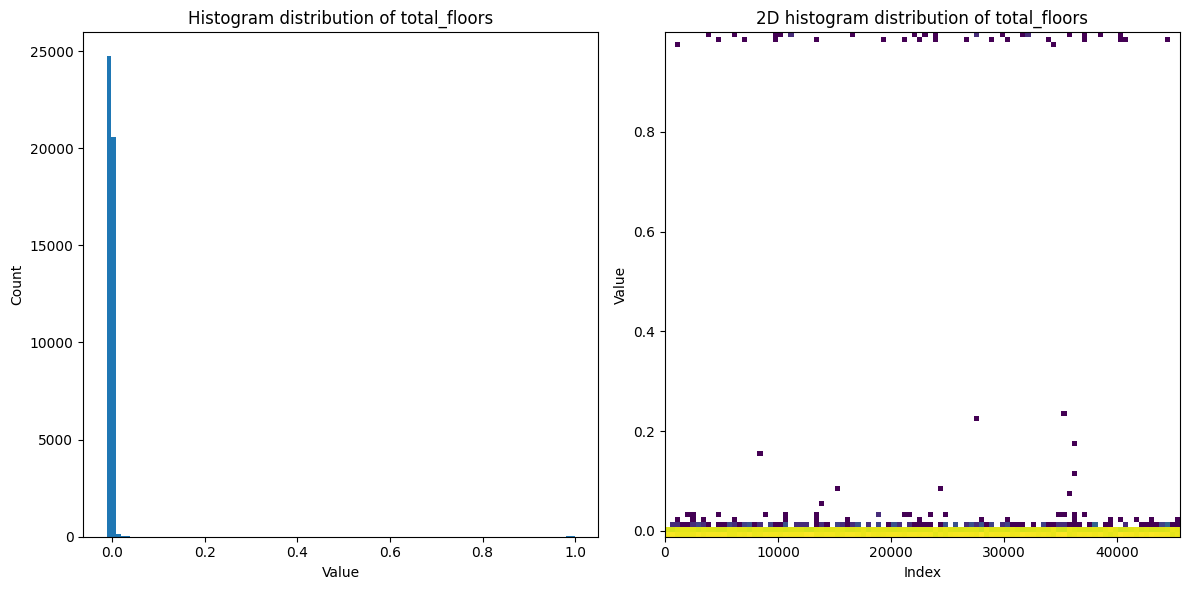

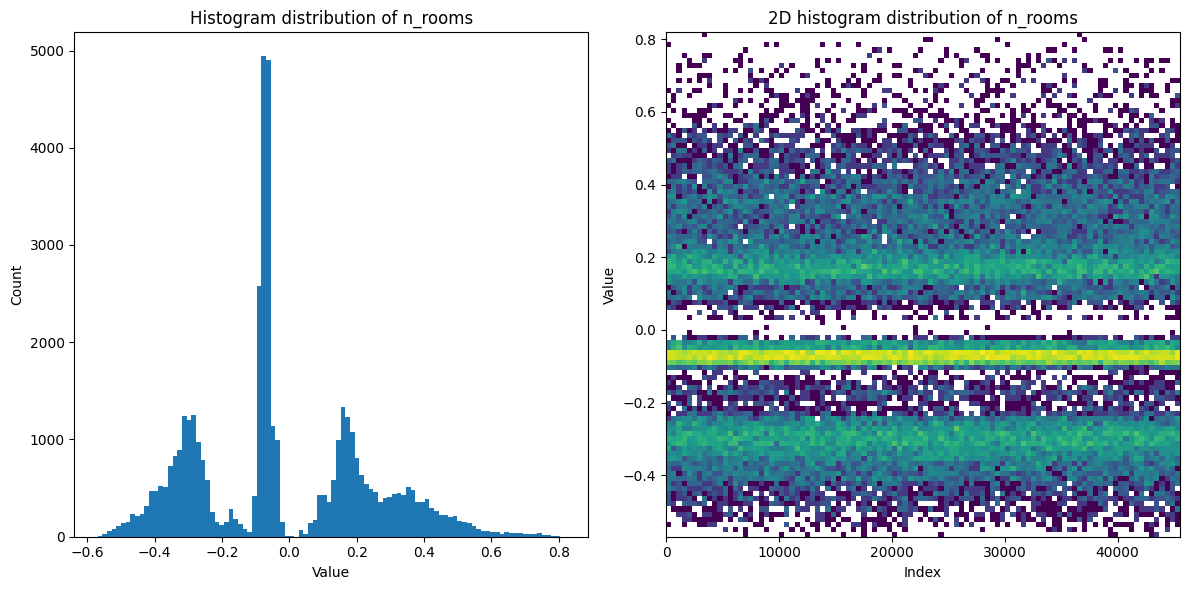

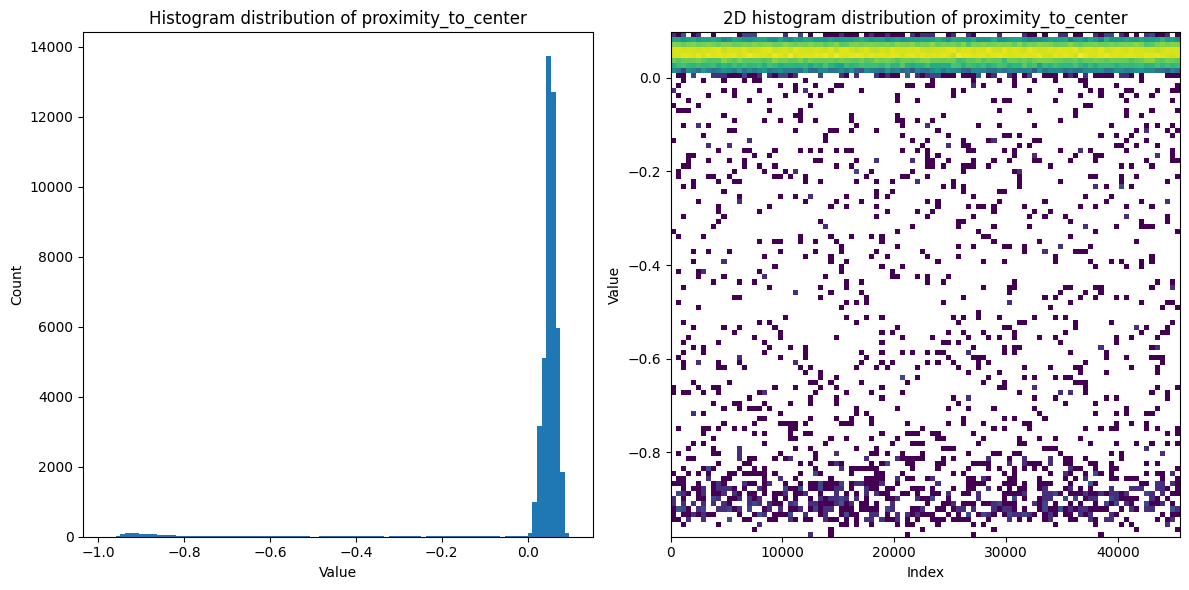

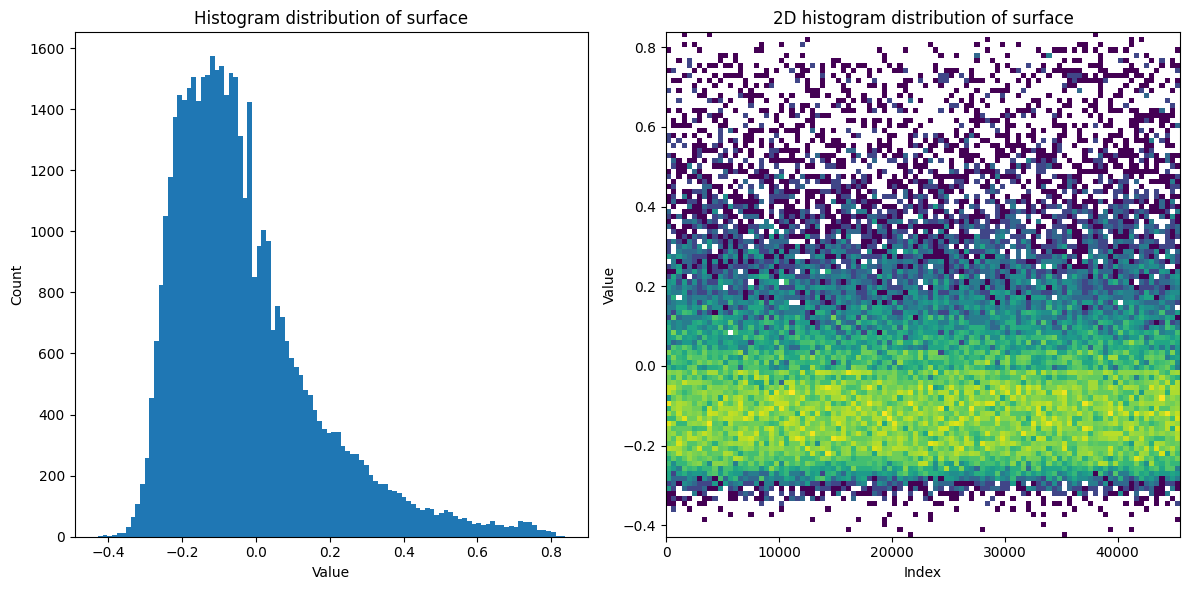

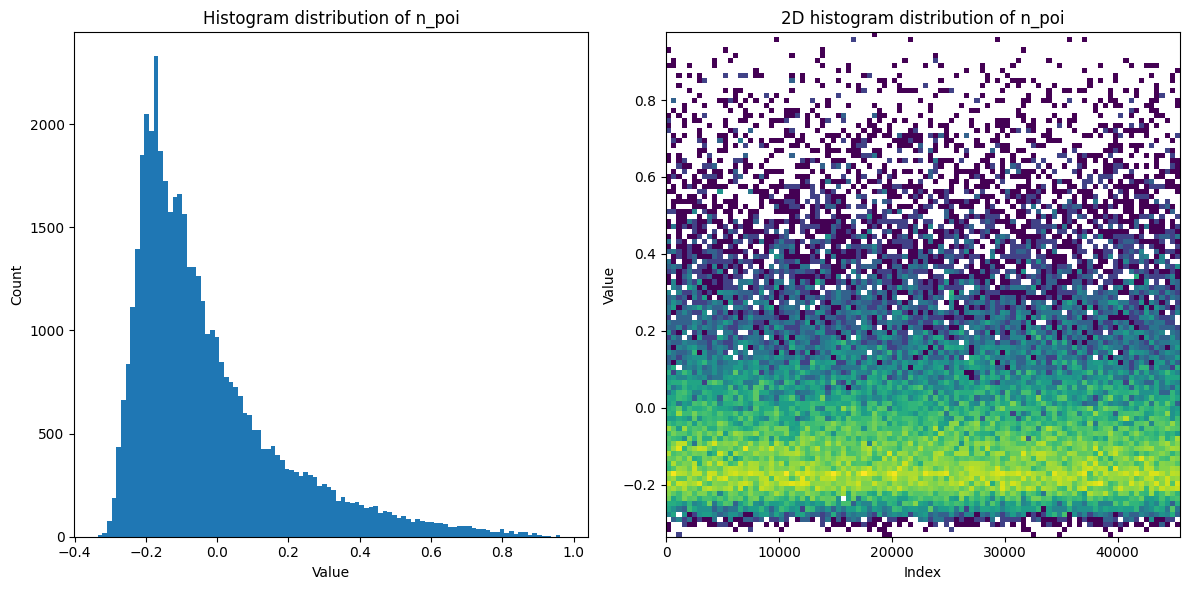

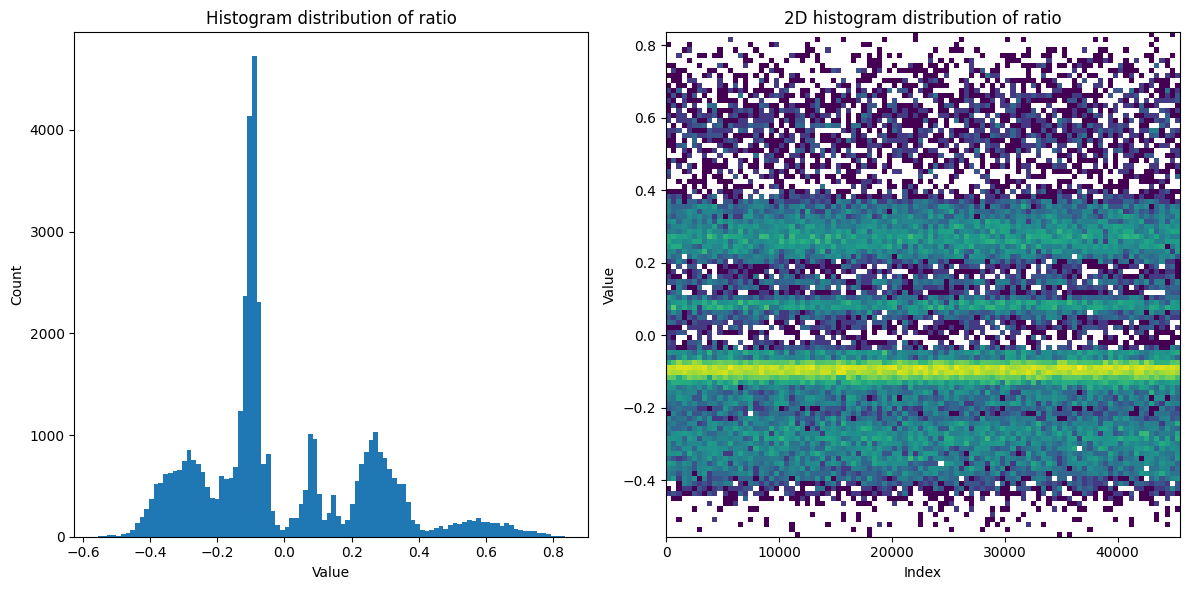

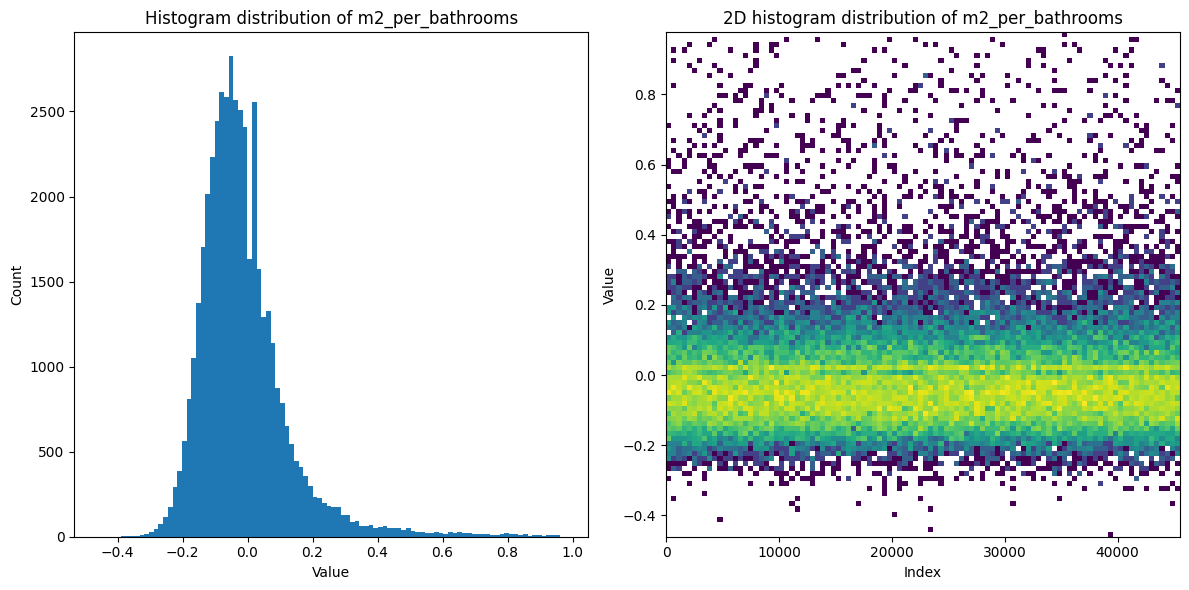

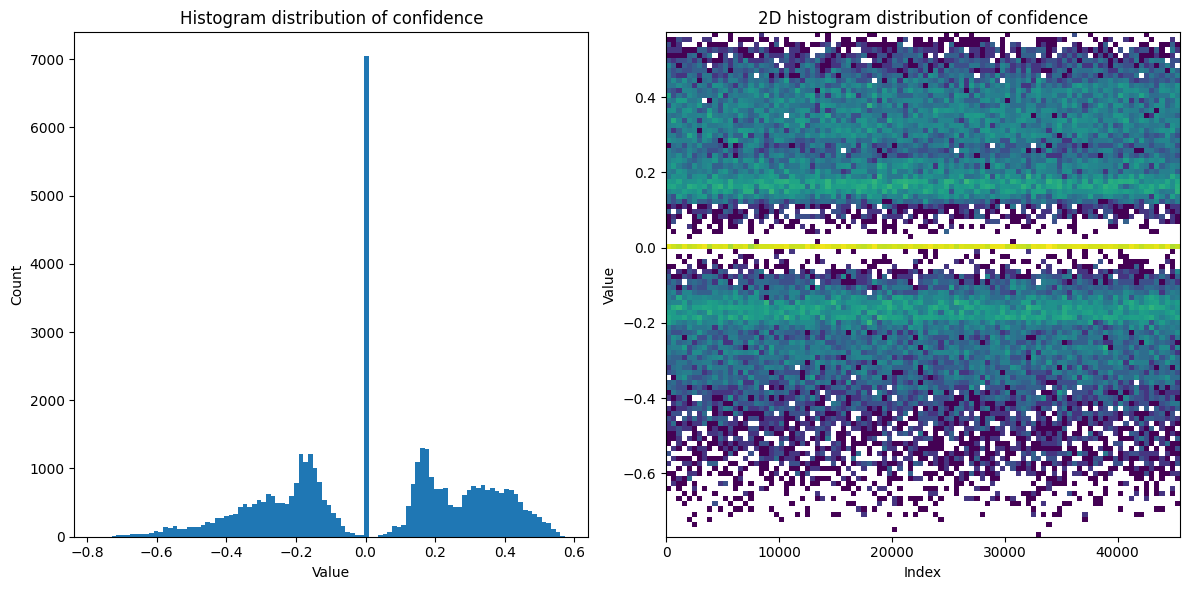

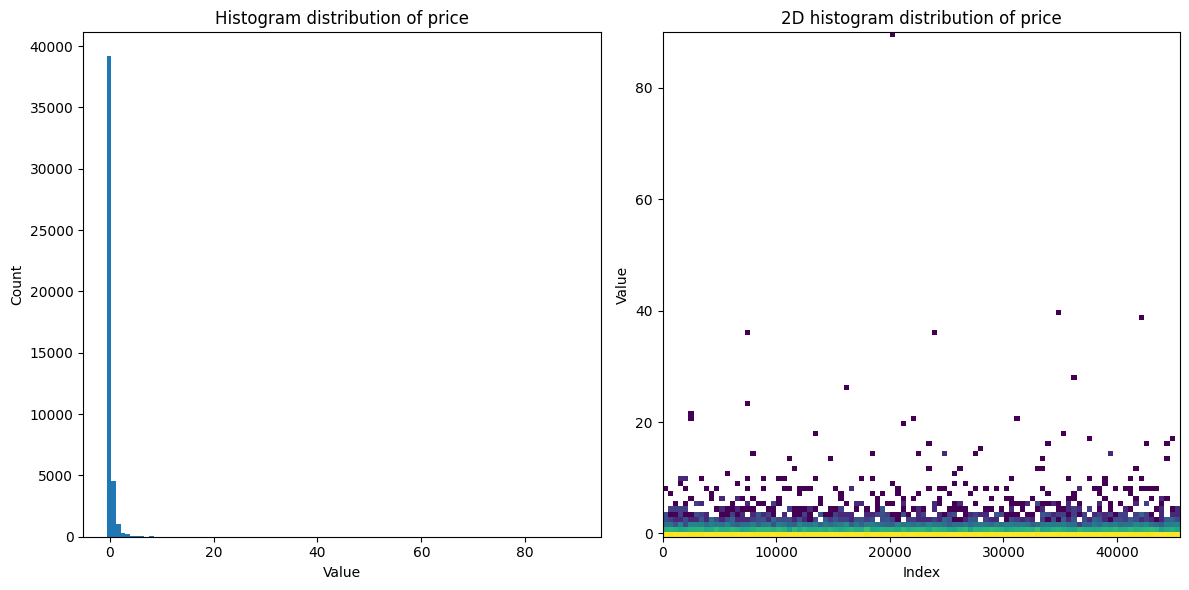

In [46]:
for col in train_df.columns:
    hist_subplot(train_df, col)

# 2.2. Drop Outliers

Droppiamo abs_z_scores < 6 tramite zscore

In [47]:
original_shape = train_df.shape[0]
z_scores = zscore(train_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 6).all(axis=1)

In [48]:
train_df = train_df[filtered_entries]
shape_t2 = train_df.shape[0]

In [49]:
print('shape before removing features with many NaNs: {}'.format(shape_t0))
print('shape after removing features with many NaNs: {}'.format(shape_t1))
print('shape difference: {}'.format(shape_t0-shape_t1))
print('percentage of removed rows: {}%'.format(round((shape_t0-shape_t1)*100/shape_t0, 2)))
print()
print('shape before removing outliers: {}'.format(shape_t1))
print('shape after removing outliers: {}'.format(shape_t2))
print('shape difference: {}'.format(shape_t1-shape_t2))
print('percentage of removed rows: {}%'.format(round((shape_t1-shape_t2)*100/shape_t1, 2)))
print()
print('shape beafore removing outliers and NaNs: {}'.format(shape_t0))
print('shape after removing outliers and NaNs: {}'.format(shape_t2))
print('shape difference: {}'.format(shape_t0-shape_t2))
print('percentage of removed rows: {}%'.format(round((shape_t0-shape_t2)*100/shape_t0, 2)))

shape before removing features with many NaNs: 46312
shape after removing features with many NaNs: 45537
shape difference: 775
percentage of removed rows: 1.67%

shape before removing outliers: 45537
shape after removing outliers: 44594
shape difference: 943
percentage of removed rows: 2.07%

shape beafore removing outliers and NaNs: 46312
shape after removing outliers and NaNs: 44594
shape difference: 1718
percentage of removed rows: 3.71%


At the end of the trasformations we plot histograms for all train_df columns

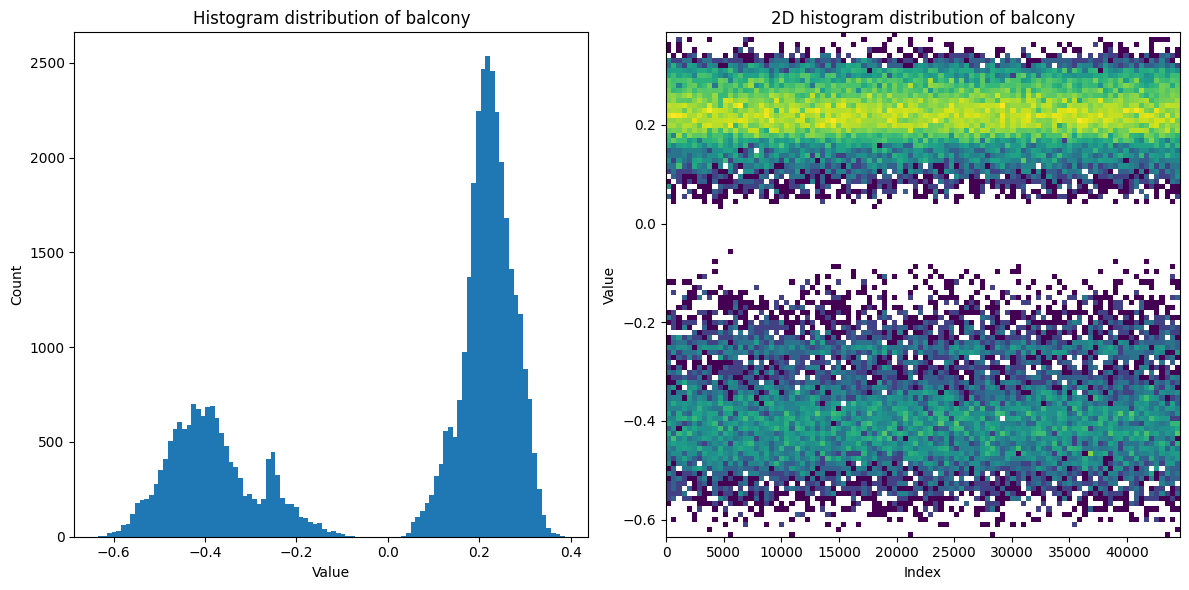

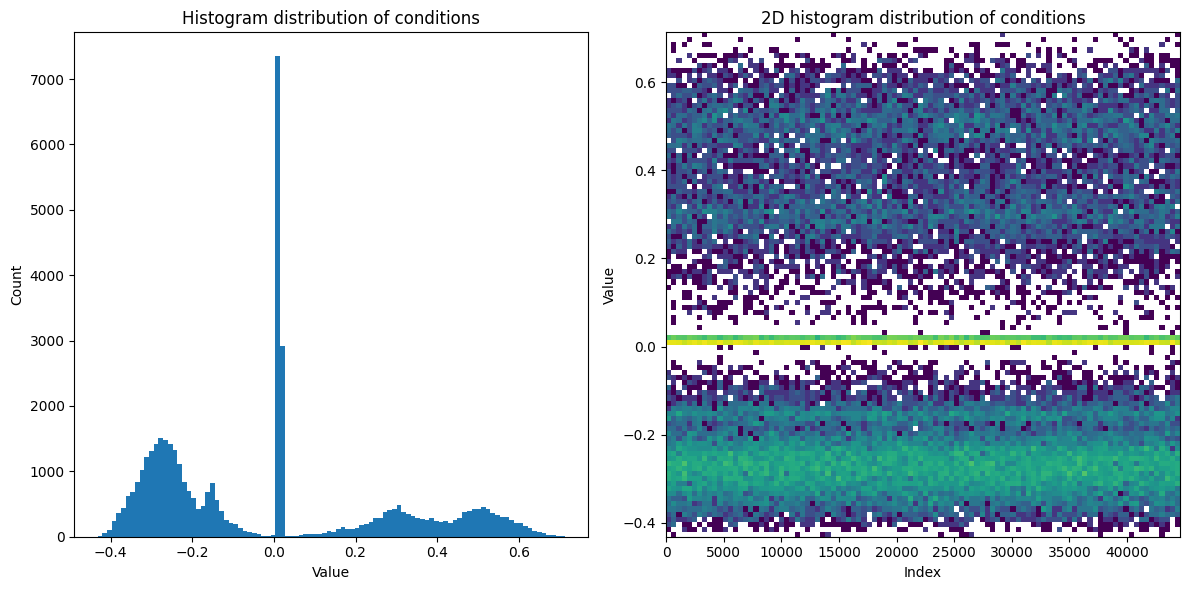

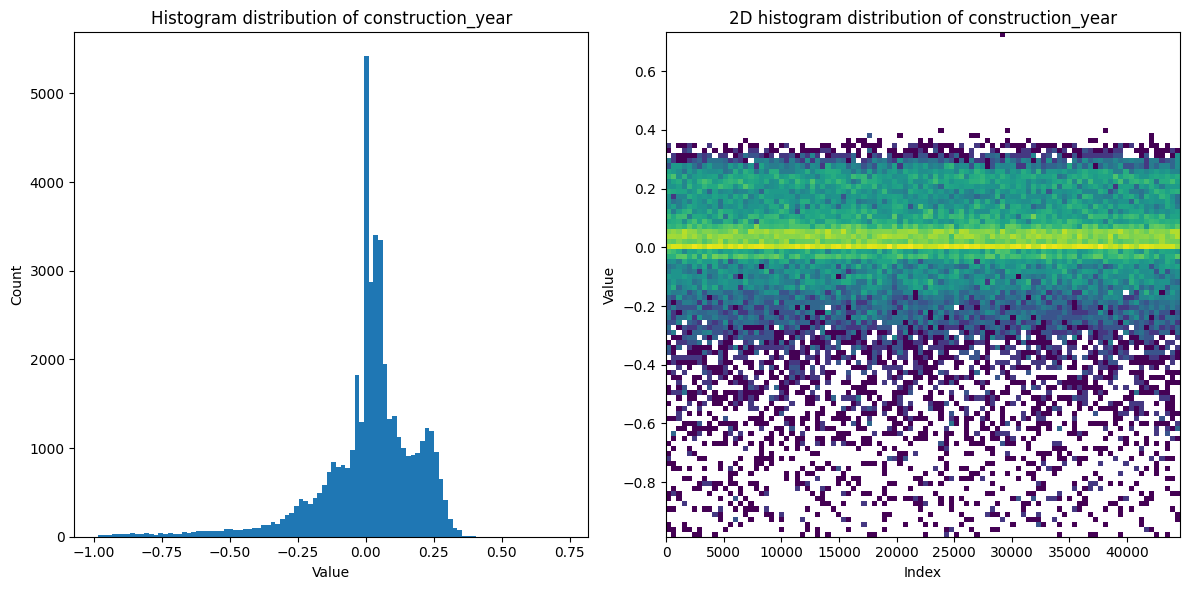

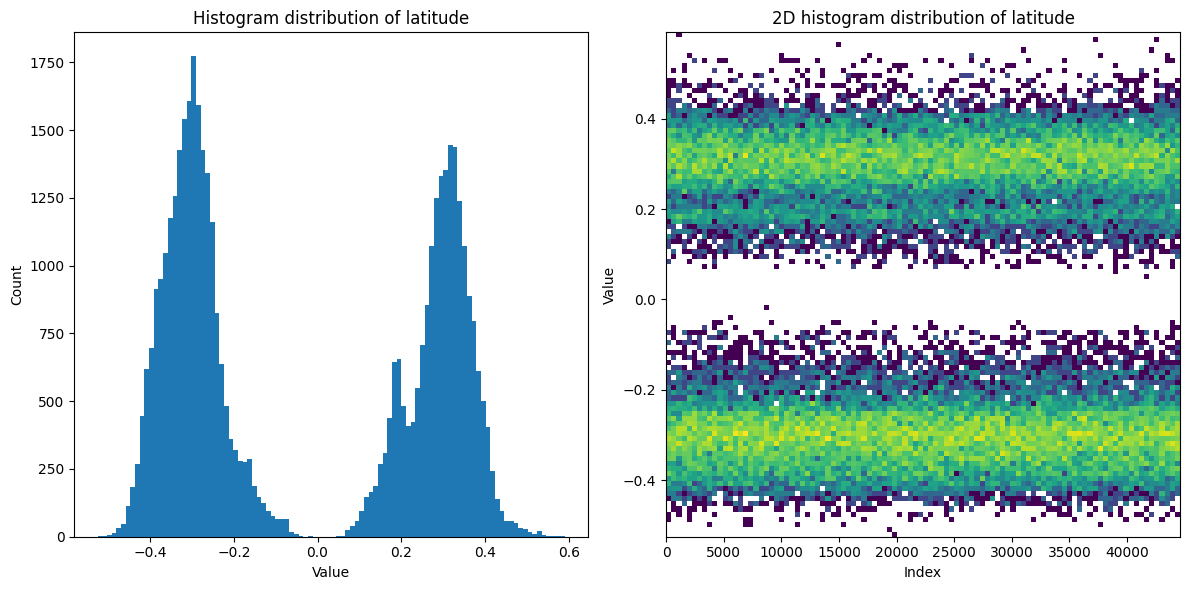

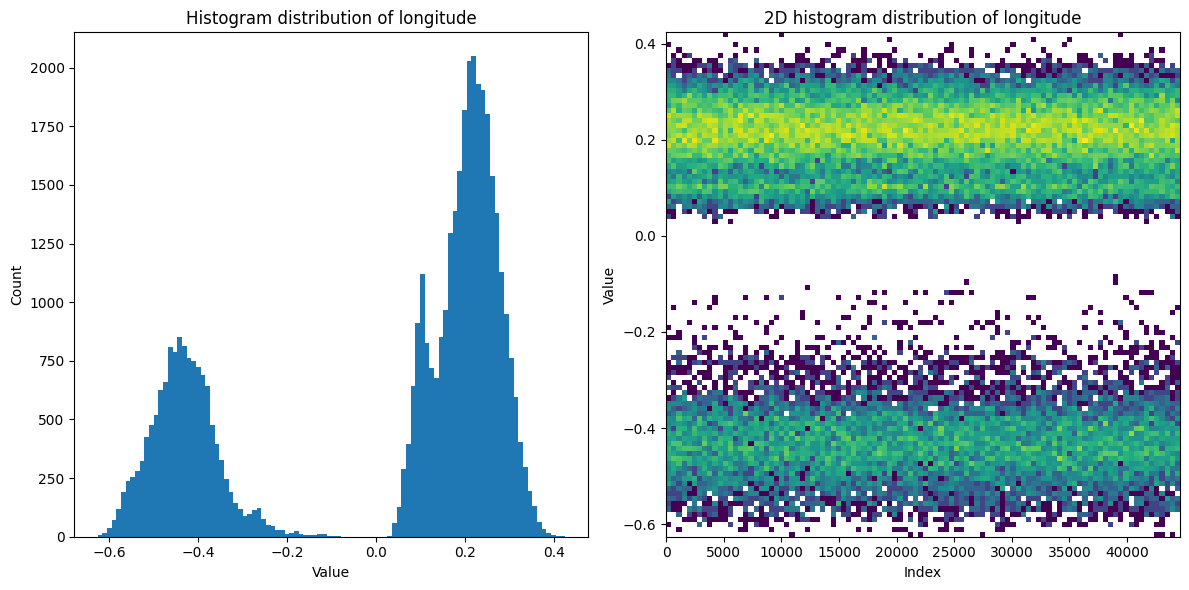

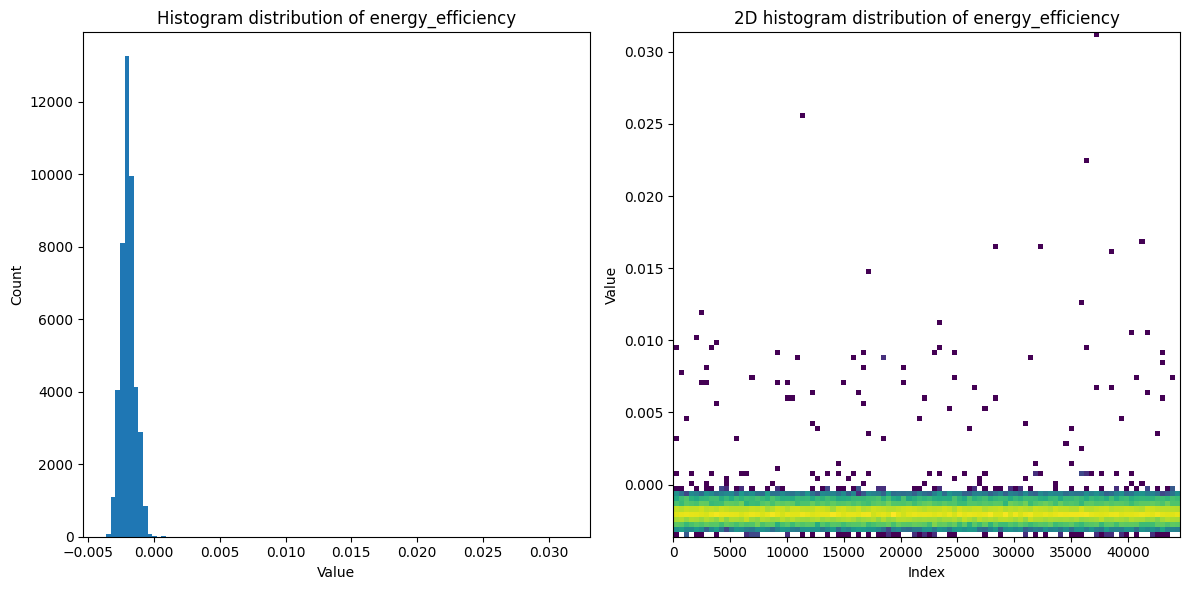

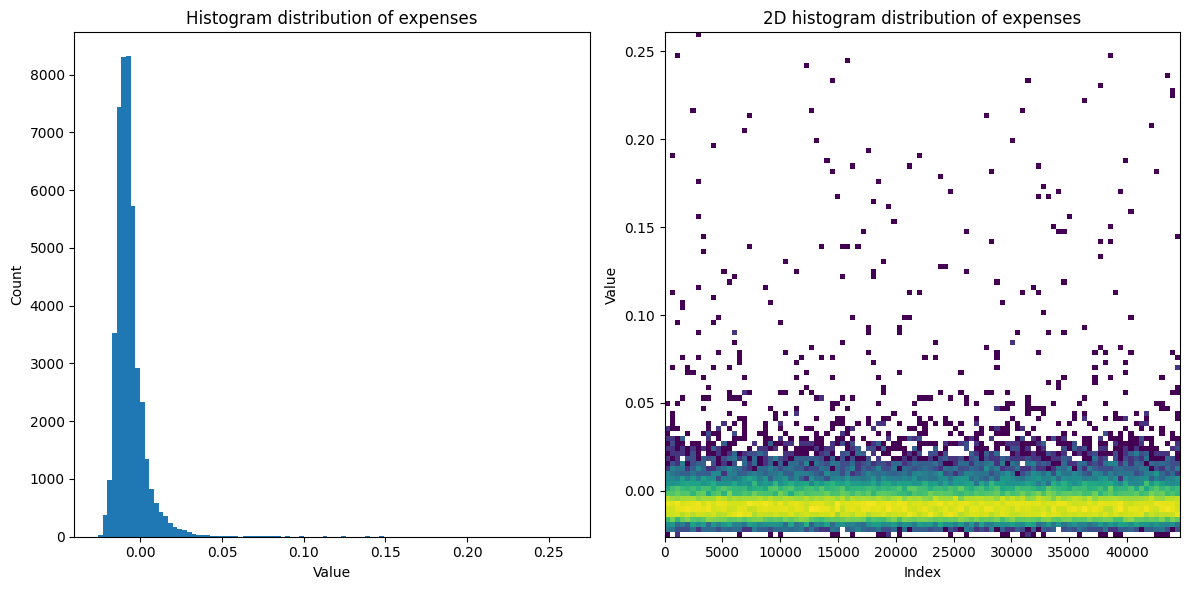

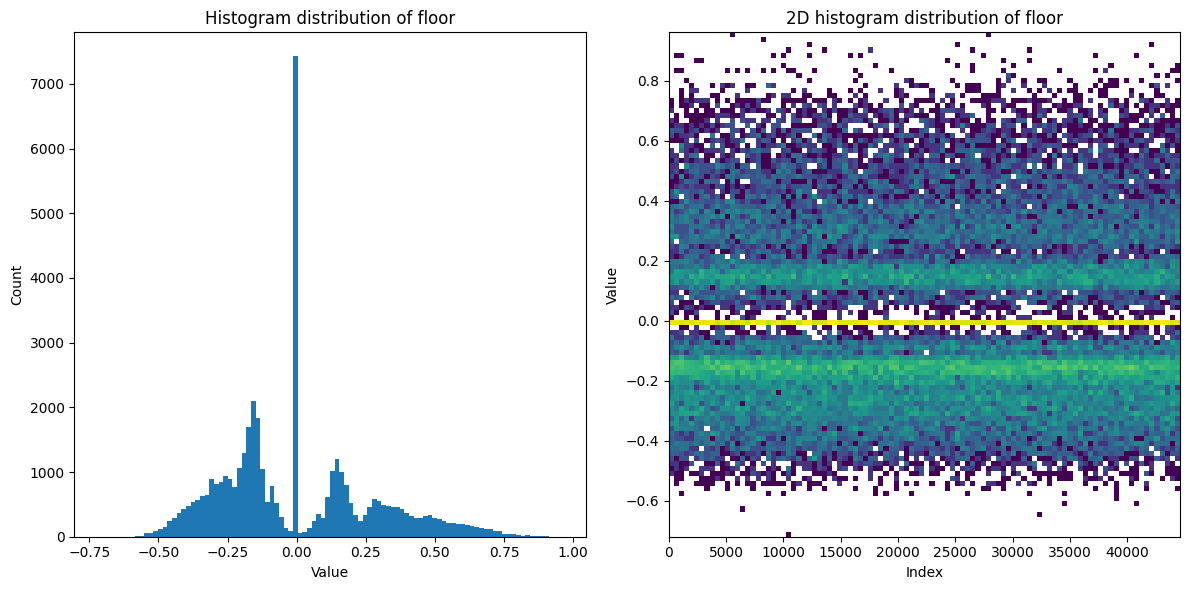

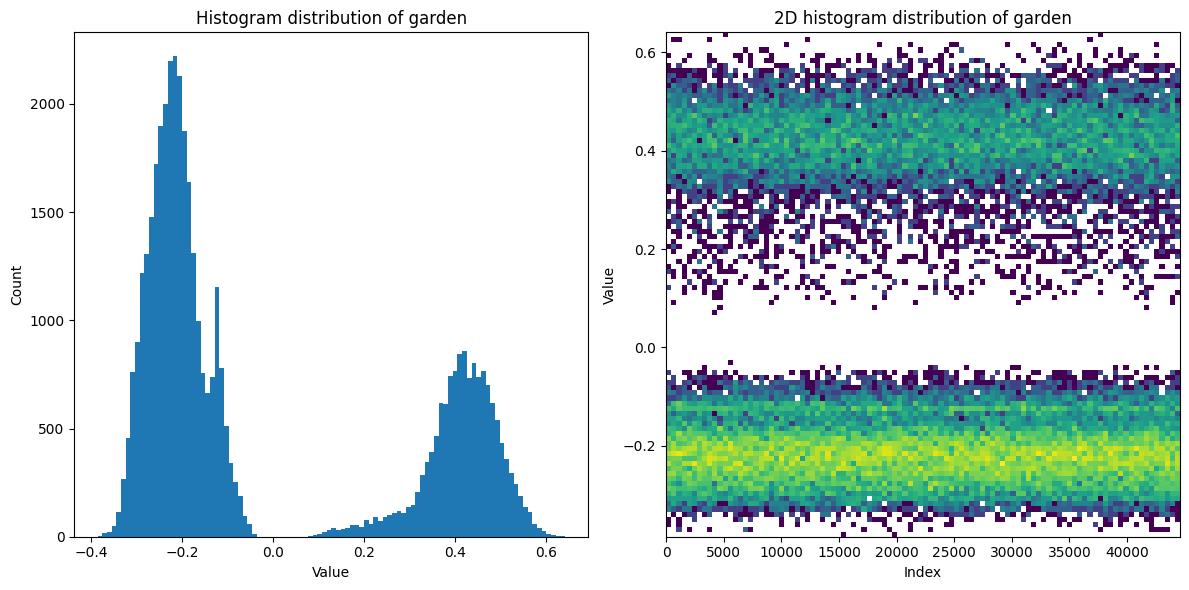

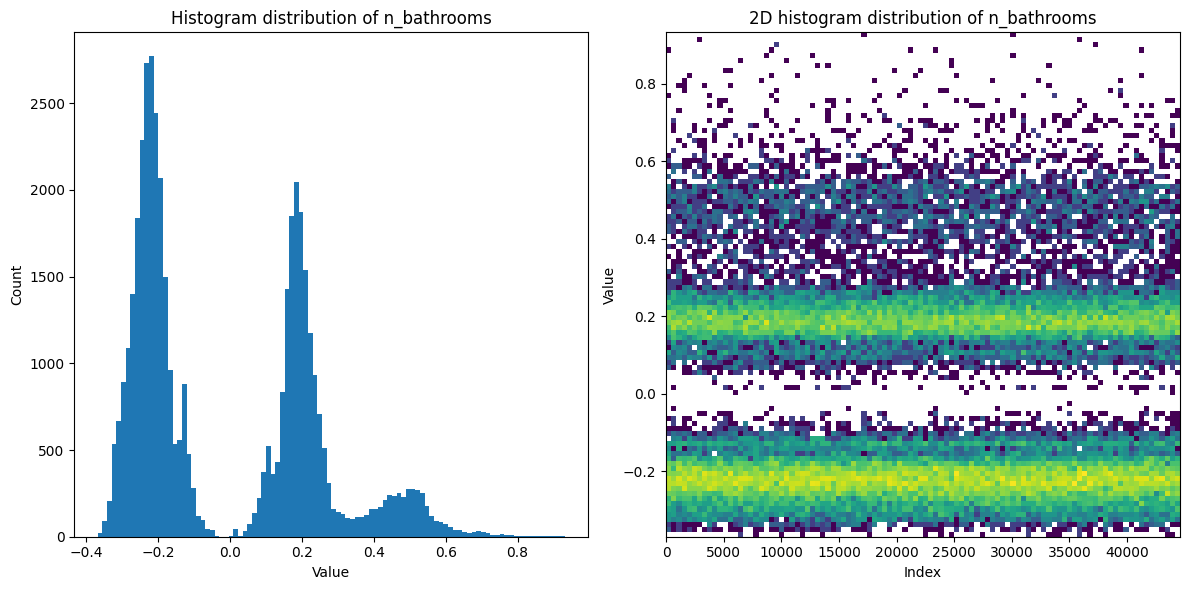

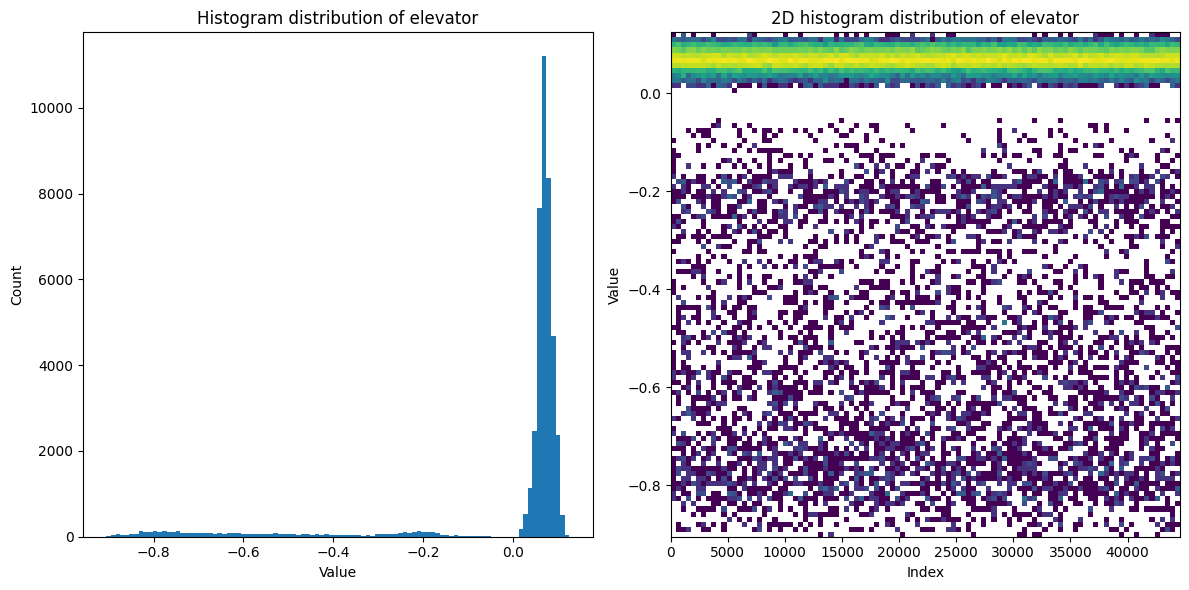

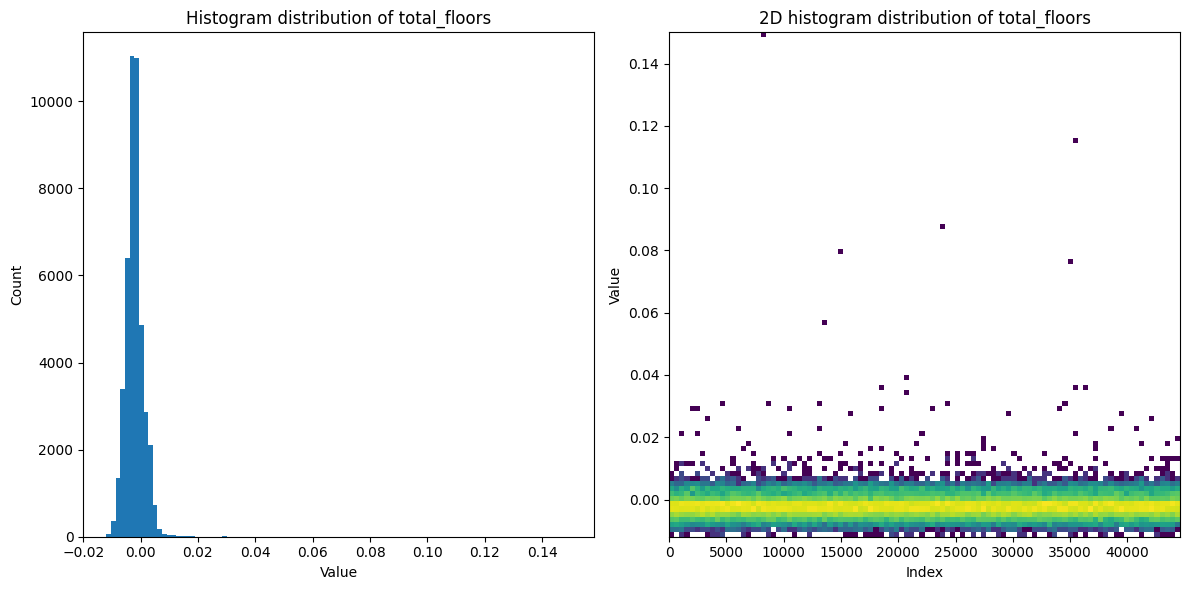

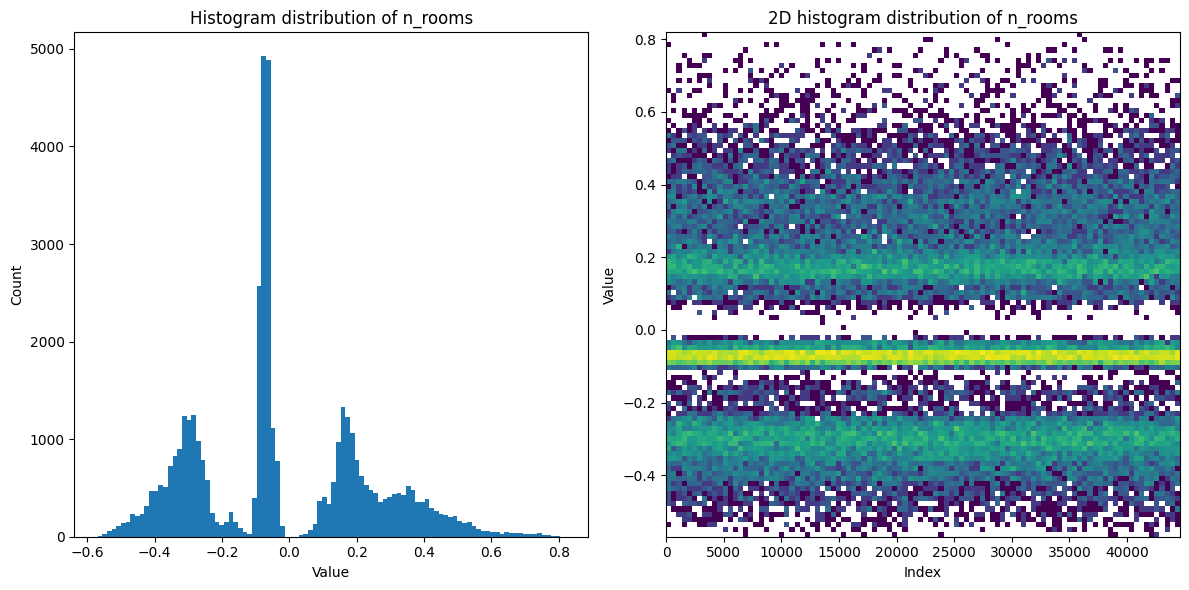

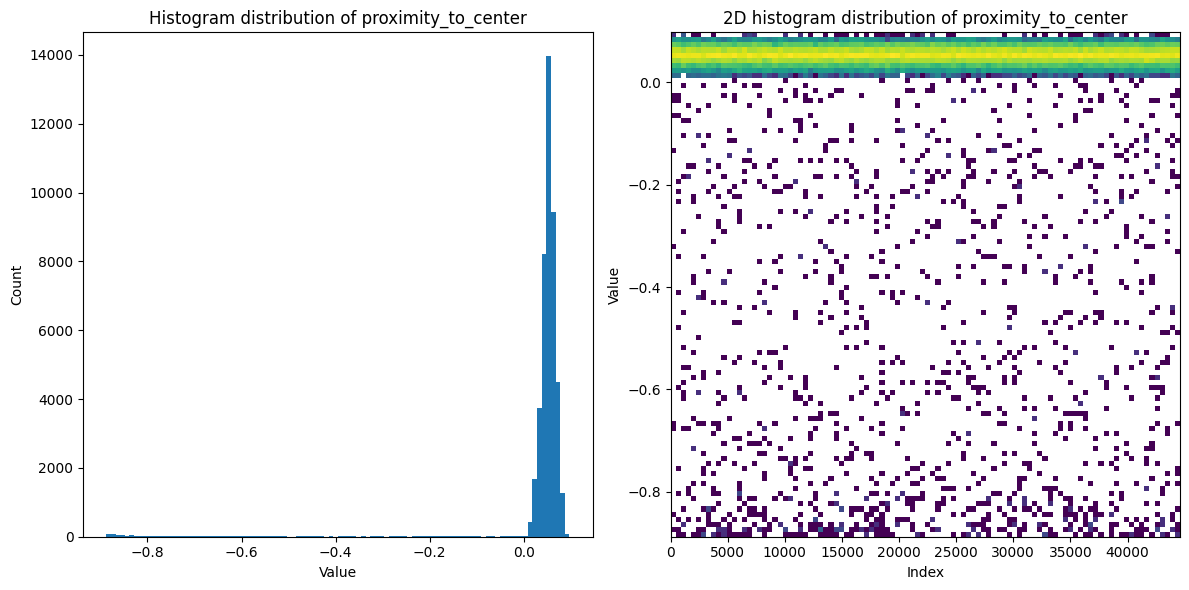

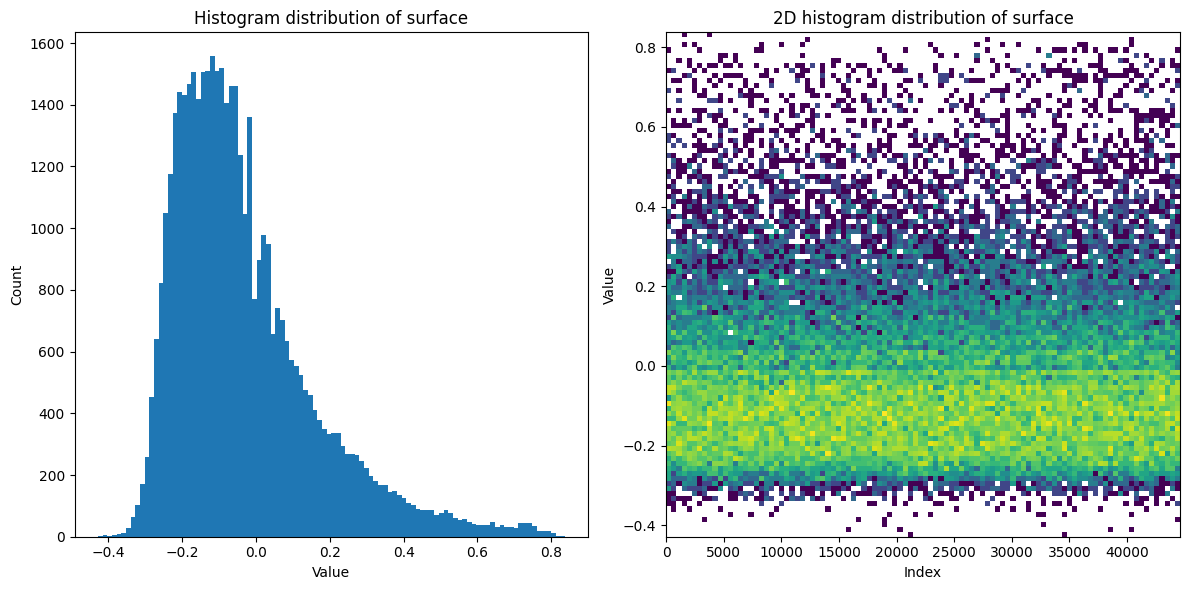

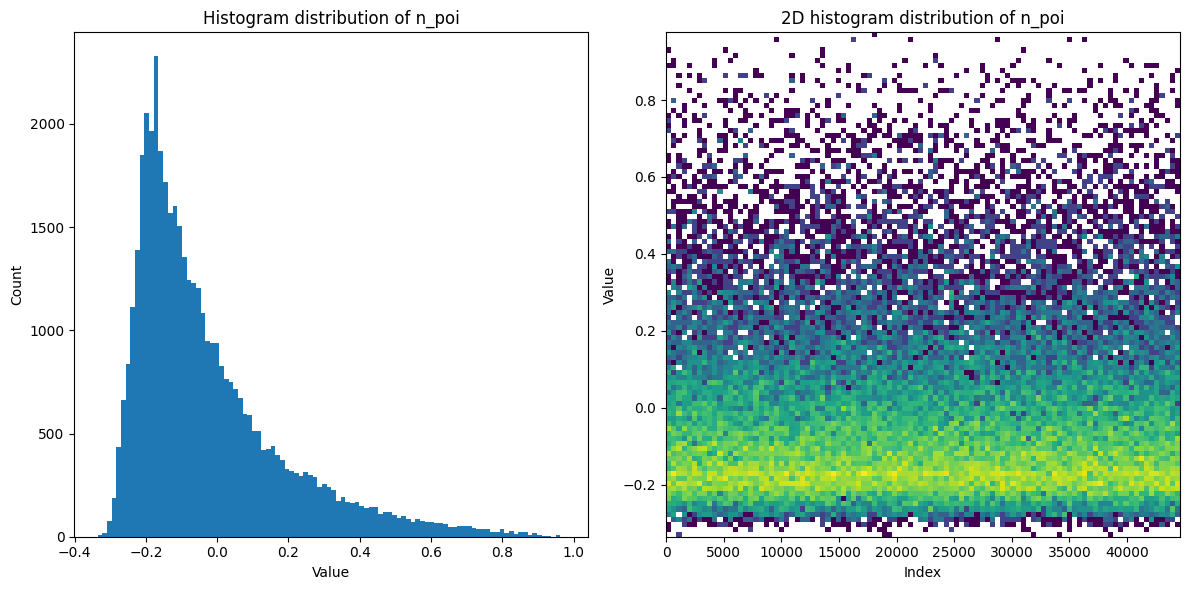

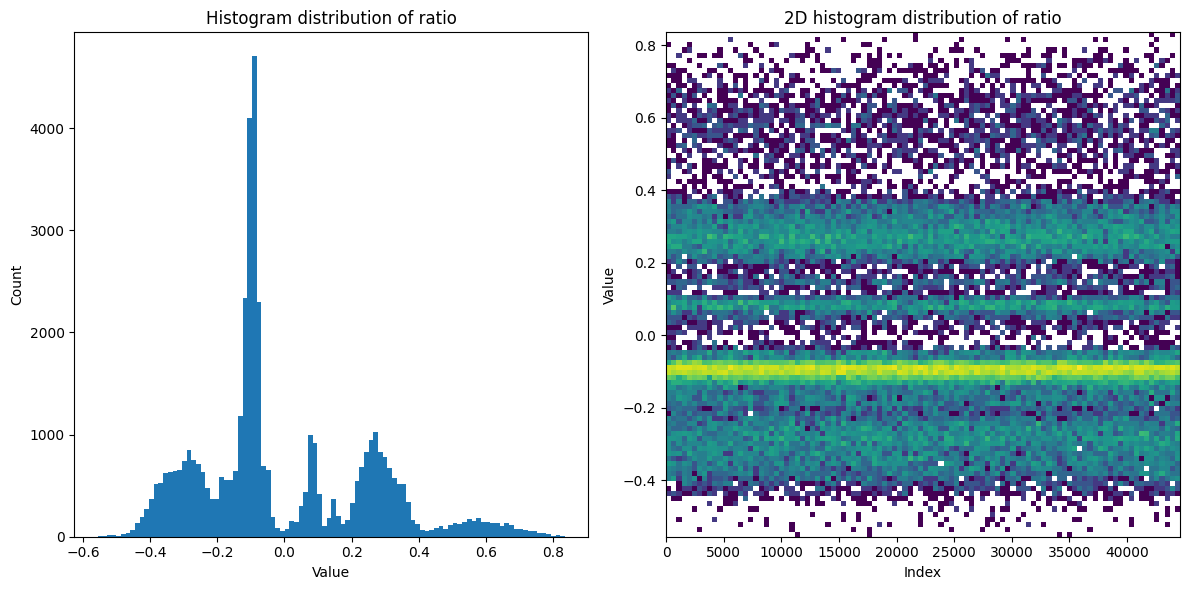

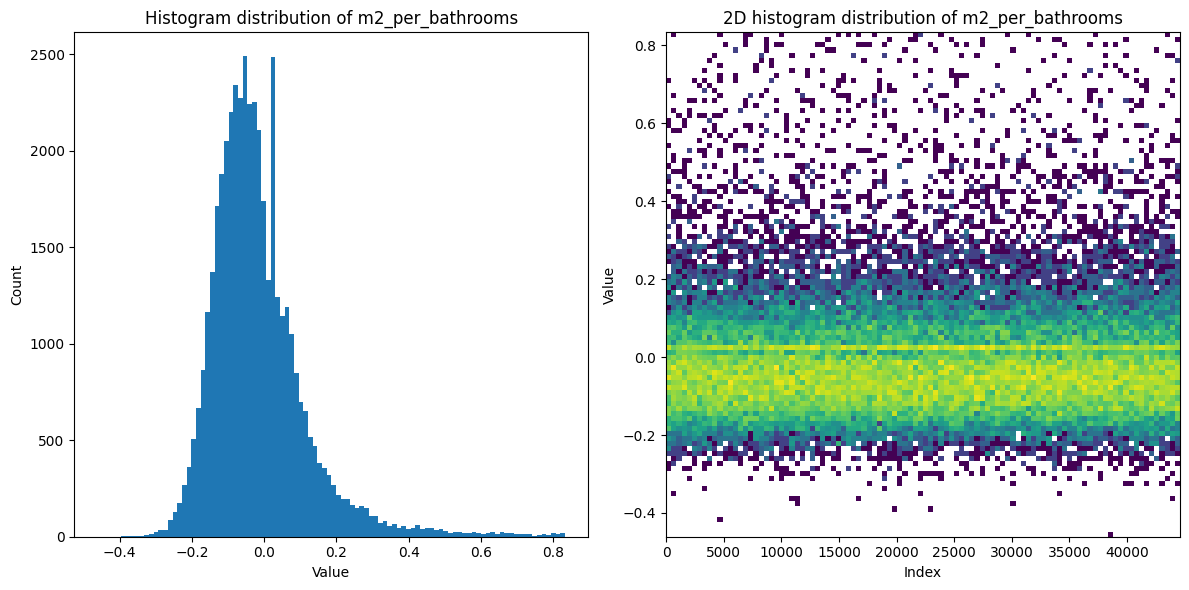

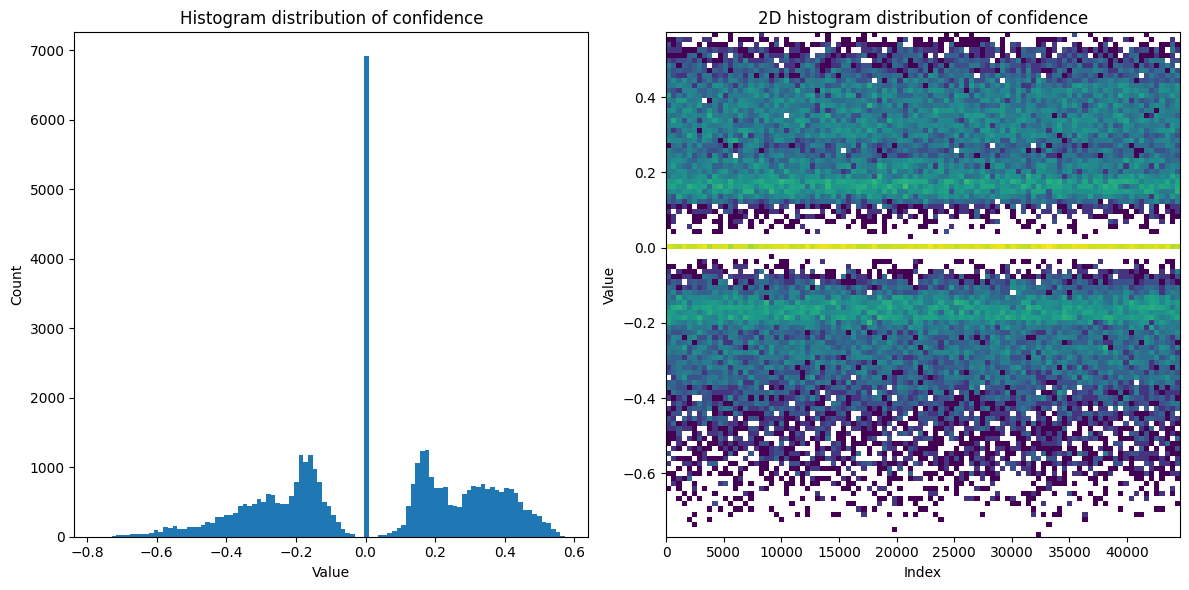

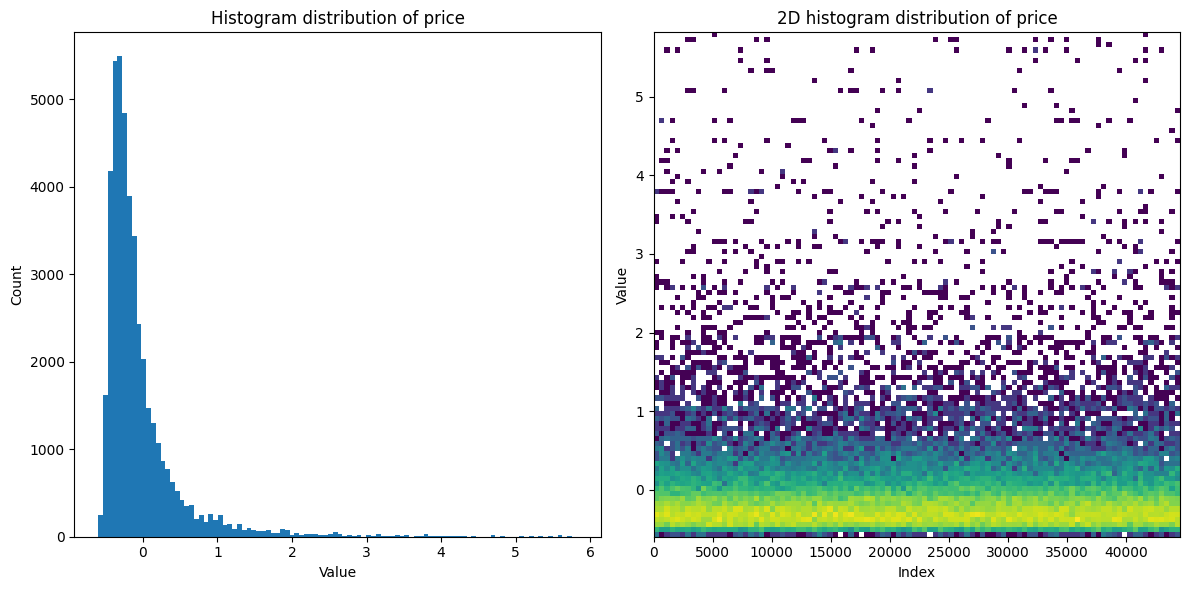

In [50]:
for col in train_df.columns:
    hist_subplot(train_df, col)

# 2.3. Feature Importance Analysis

PLottiamo la correlation matrix

<Axes: >

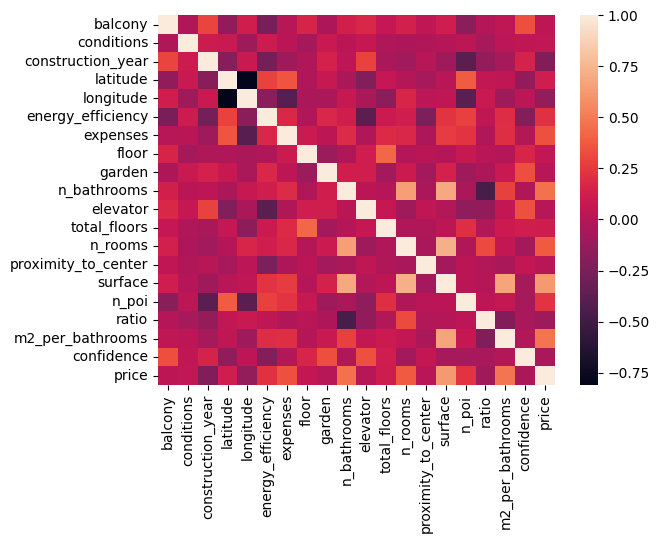

In [51]:
sns.heatmap(train_df.corr())

Performiamo la feature importance analisys im modo da capire quanto ogni feature è utile all'apprendimento

In [52]:
x_train = train_df.drop('price', axis=1)
y_train = train_df['price']

In [53]:
# compute feature_importances
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(x_train, y_train)
sorted(rf.feature_importances_, reverse=True)

[0.421856450563521,
 0.15057142045592387,
 0.05191683604906732,
 0.04838985821222707,
 0.041873859297798056,
 0.03439335888994454,
 0.024718265652400248,
 0.02451866504880226,
 0.023854422231042442,
 0.023757259413719835,
 0.022466572132569477,
 0.02017999103748536,
 0.019735011343397862,
 0.019253596829984686,
 0.01792900239526811,
 0.017473665204322707,
 0.013037641938417888,
 0.012158800431241052,
 0.011915322872866358]

<BarContainer object of 19 artists>

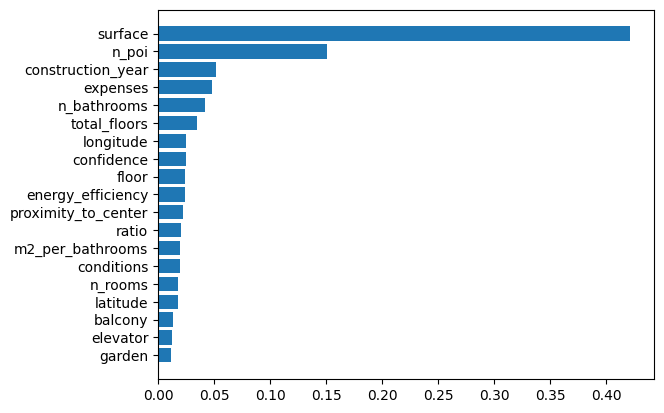

In [54]:
# plot feature_importances
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_train.columns[sorted_idx], rf.feature_importances_[sorted_idx])

# 4. Training

In [55]:
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'MLPRegressor': MLPRegressor(),
    'SVR': SVR()
}

In [56]:
for model_name, model in models.items():
    print('model: {}'.format(model_name))
    model.fit(x_train, y_train)

model: LinearRegression
model: RandomForestRegressor
model: GradientBoostingRegressor
model: KNeighborsRegressor
model: DecisionTreeRegressor
model: MLPRegressor
model: SVR


# 5. Evaluation

In [57]:
def evaluate_model(model, x, y, y_scaler, scoring='neg_mean_squared_error'):
    scores = cross_val_score(model, x, y, cv=5, scoring=scoring, n_jobs=-1)
    y_pred = cross_val_predict(model, x, y, cv=5, n_jobs=-1)
    print('scores: {}'.format(scores))
    print('mean: {}'.format(-scores.mean()))
    print('std: {}'.format(scores.std()))
    # plot scatter plot of y_pred vs y_true
    y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
    y = y_scaler.inverse_transform(y.values.reshape(-1, 1))
    plt.scatter(y, y_pred)
    plt.plot([0, max(y.max(), y_pred.max())], [0, max(y.max(), y_pred.max())], 'r--', lw=2)
    plt.title('{}'.format(model))
    plt.xlabel('y_true')
    plt.ylabel('y_pred')
    plt.show()
    plt.close()
    return scores

In [58]:
performance = {model_name: {'MSE_mean': 0.0, 'MSE_std': 0.0} for model_name in models.keys()}

model: LinearRegression
scores: [-0.17248631 -0.16027886 -0.1554977  -0.17151142 -0.16408092]
mean: 0.16477104100433188
std: 0.006505518800264932


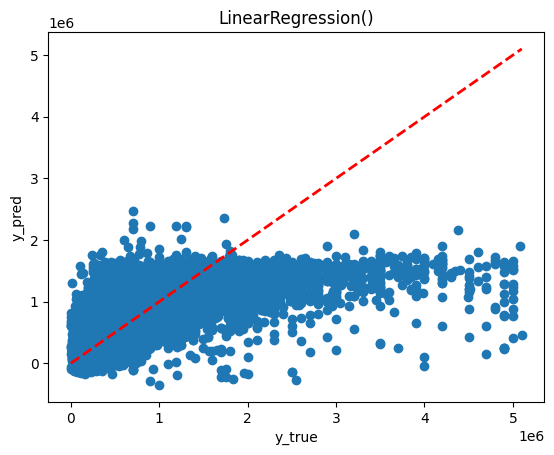

model: RandomForestRegressor
scores: [-0.10898074 -0.09622571 -0.09974477 -0.11023715 -0.09946037]
mean: 0.10292974943153547
std: 0.005606022459839946


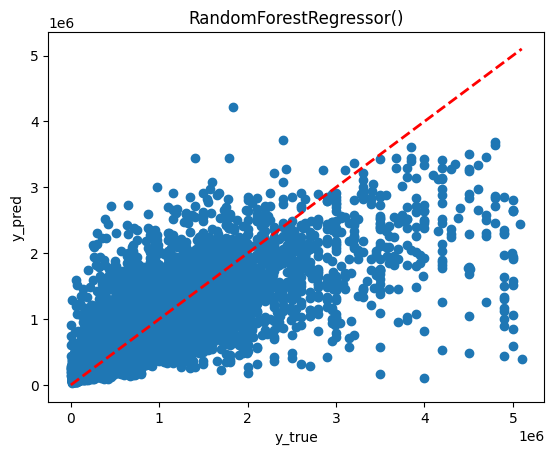

model: GradientBoostingRegressor
scores: [-0.12326665 -0.10517124 -0.11162486 -0.12583283 -0.11090352]
mean: 0.11535981865459892
std: 0.007871690361577548


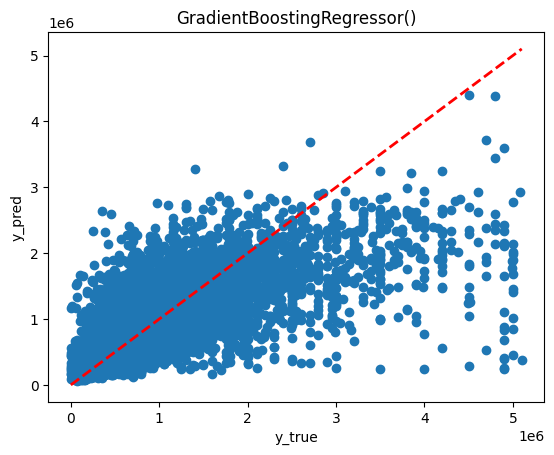

model: KNeighborsRegressor
scores: [-0.13955595 -0.12633047 -0.13021229 -0.1396026  -0.1294885 ]
mean: 0.1330379612530233
std: 0.0054982218457760535


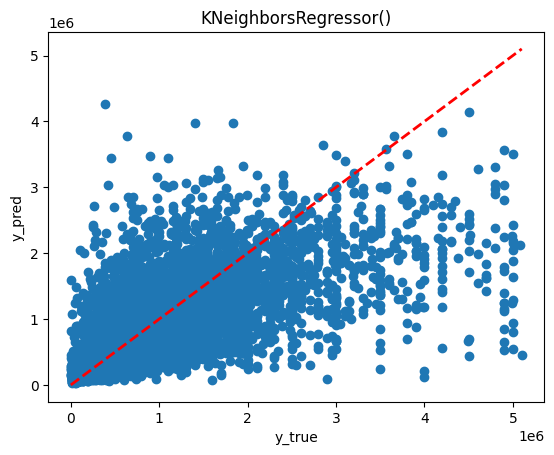

model: DecisionTreeRegressor
scores: [-0.22185425 -0.20200834 -0.20403294 -0.21017874 -0.21780099]
mean: 0.21117505109800558
std: 0.007667847770020043


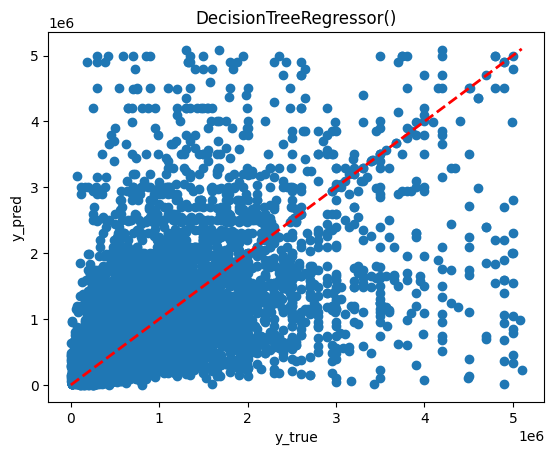

model: MLPRegressor
scores: [-0.11334038 -0.10451944 -0.10691411 -0.1183022  -0.10692282]
mean: 0.1099997887301171
std: 0.005081591148746013


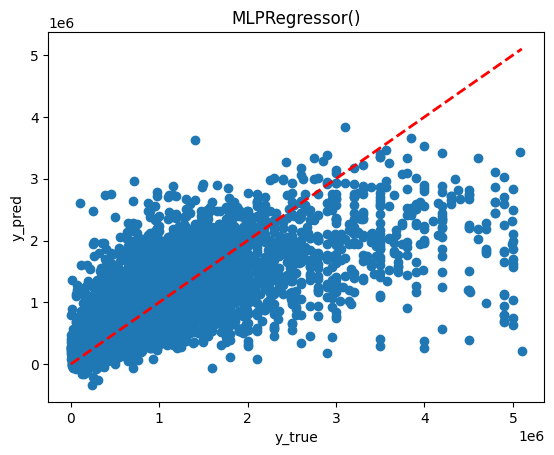

model: SVR
scores: [-0.12133631 -0.1131732  -0.10873914 -0.1251089  -0.11064266]
mean: 0.11580004110480344
std: 0.00633498974599507


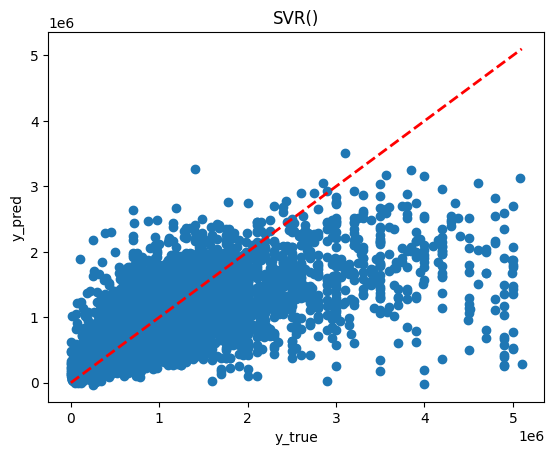

In [59]:
for model_name, model in models.items():
    print('model: {}'.format(model_name))
    MSE_scores = evaluate_model(model, x_train, y_train, y_scaler, scoring='neg_mean_squared_error')
    performance[model_name]['MSE_mean'] = -MSE_scores.mean()
    performance[model_name]['MSE_std'] = MSE_scores.std()

In [60]:
performance_df = pd.DataFrame.from_dict(performance, orient='index').sort_values(by='MSE_mean').reset_index().rename(columns={'index': 'model'})
performance_df

model  MSE_mean   MSE_std
0      RandomForestRegressor  0.102930  0.005606
1               MLPRegressor  0.110000  0.005082
2  GradientBoostingRegressor  0.115360  0.007872
3                        SVR  0.115800  0.006335
4        KNeighborsRegressor  0.133038  0.005498
5           LinearRegression  0.164771  0.006506
6      DecisionTreeRegressor  0.211175  0.007668

# 6. Submission

In [61]:
def x_test_preprocessing(x_test, poi_df, map_conditions, x_scaler, x_imputer, x_normalizer):
    x_test['n_poi'] = x_test.apply(lambda x: get_n_poi(x['latitude'], x['longitude'], poi_df), axis=1)
    x_test['ratio'] = x_test.apply(lambda x: lambda_ratio(x), axis=1)
    x_test['m2_per_bathrooms'] = x_test.apply(lambda x: lambda_m2_per_bathrooms(x), axis=1)
    x_test['confidence'] = x_test.shape[1] - x_test.isna().sum(axis=1) - 2 # 2 corrisponde a non contare balcony e garden che per costruzione non sono mai NaN
    x_test['garden'] = x_test['garden'].fillna(False)
    x_test['balcony'] = x_test['balcony'].fillna(False)
    x_test['garden'] = x_test['garden'].apply(lambda x: 1 if x == True else 0)
    x_test['balcony'] = x_test['balcony'].apply(lambda x: 1 if x == True else 0)
    x_test['conditions'] = x_test['conditions'].apply(lambda x: map_conditions[x])
    x_test['conditions'] = x_test['conditions'].apply(lambda x: np.nan if x == map_conditions[np.nan] else x)
    x_test = pd.DataFrame(x_scaler.transform(x_test), columns=x_test.columns)
    x_test = pd.DataFrame(x_imputer.transform(x_test), columns=x_test.columns)
    x_test = pd.DataFrame(x_normalizer.transform(x_test), columns=x_test.columns)
    return x_test

In [62]:
test_id = test_df['id']
x_test = test_df.drop('id', axis=1)
x_test = x_test_preprocessing(x_test, poi_df, map_conditions, x_scaler, x_imputer, x_normalizer)

In [63]:
def submission(model, filename, x_test, y_scaler):
    y_pred = y_scaler.inverse_transform(model.predict(x_test).reshape(-1, 1))
    y_pred = pd.DataFrame(y_pred, columns=['price'])
    submission_df = pd.concat([test_id, y_pred], axis=1)
    submission_df.to_csv(filename, index=False)
    return

In [64]:
for model_name, model in models.items():
    submission(model, 'submission/{}.csv'.format(model_name), x_test, y_scaler)

# 7. Tuning

- troviamo la combinazione di iperparametri migliori per il modello migliore che abbiamo fino ad ora ottenuto
- quindi accordiamo il modello migliore

In [65]:
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [None, 10, 15],
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False]
}
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=2)
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=200; total time=  30.1s
[CV] END bootstrap=True, max_depth=None, max_features=log2, n_estimators=200; total time=  30.2s
[CV] END bootstrap=True, max_depth=None, max_features=log2, n_estimators=200; total time=  31.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=200; total time=  31.2s
[CV] END bootstrap=True, max_depth=None, max_features=log2, n_estimators=200; total time=  31.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=200; total time=  33.0s
[CV] END bootstrap=True, max_depth=None, max_features=log2, n_estimators=300; total time=  41.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=300; total time=  42.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=300; total time=  42.9s
[CV] END bootstrap=True, max_depth=None, max_features=log2, n_est

/home/vincenzo/.anaconda3/envs/stable/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, n_estimators=200; total time=  20.7s
[CV] END bootstrap=True, max_depth=None, max_features=log2, n_estimators=400; total time=  53.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=400; total time=  53.8s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, n_estimators=200; total time=  20.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=400; total time=  54.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=400; total time=  56.5s
[CV] END bootstrap=True, max_depth=None, max_features=log2, n_estimators=400; total time=  56.6s
[CV] END bootstrap=True, max_depth=None, max_features=log2, n_estimators=400; total time=  57.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, n_estimators=200; total time=  19.5s
[CV] END bootstrap=True, max_depth=10, max_features=None, n_estimators=200; total time= 1.1min
[CV] END bootstrap=True, max_depth=10,

GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 15],
                         'max_features': [None, 'sqrt', 'log2'],
                         'n_estimators': [200, 300, 400]},
             scoring='neg_mean_squared_error', verbose=2)

In [66]:
best_params = grid_search.best_params_
best_params

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'n_estimators': 400}

scores: [-0.1011894  -0.08982411 -0.09340641 -0.10519739 -0.09299812]
mean: 0.09652308540527774
std: 0.005727711536382648


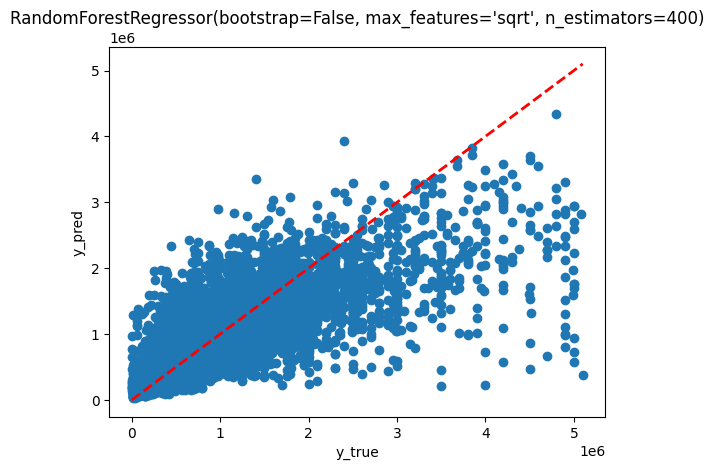

MSE: 0.097 (0.006 std)


In [67]:
tuned_model = RandomForestRegressor(**best_params)
tuned_model.fit(x_train, y_train)
MSE_score = evaluate_model(tuned_model, x_train, y_train, y_scaler, scoring='neg_mean_squared_error')
print('MSE: {:.3f} ({:.3f} std)'.format(-MSE_score.mean(), MSE_score.std()))

In [68]:
submission(tuned_model, 'submission/tuned_model.csv', x_test, y_scaler)